# Coverage depth analysis

Coverage depth histogram

In [ ]:
from common import *
import numpy as np 
import pandas as pd

drop_cols = ["percentMeth_C", "percentMeth_5mC", "percentMeth_5hmC", "strand"]

prom_raw = readModbam2bed("/mnt/data1/doh28/data/prom_R10.4.1_E8.2_WGS_brain_DH/dorado_0.3.2_basecalls/modbases/cbm1_prom_modbases_mapq60.bed", 1, False).drop(columns=drop_cols).assign(method = "Nanopore")
oxbs_raw = readBismarkZeroCov("/mnt/data1/doh28/data/CRR008808_oxBS/extraction_output/mapq_filter/CRR008808_oxBS_merged.bedGraph.gz.bismark.zero.cov", "5mC", 1, False).drop(columns=drop_cols, errors="ignore").assign(method = "oxBS-seq")
tab_raw = readBismarkZeroCov("/mnt/data1/doh28/data/CRR008807_TAB/mapq_filtered/modified_bases/CRR008807_TAB_merged_resorted_q10.bedGraph.gz.bismark.zero.cov", "5hmC", 1, False).drop(columns=drop_cols, errors="ignore").assign(method = "TAB-seq")

histogram_df = pd.concat([prom_raw, oxbs_raw, tab_raw])

In [ ]:
min_1_raw = readModbam2bed("/mnt/data1/doh28/data/cbm1_wgs_07_08_23/modified_bases/cbm1_wgs_07_08_23_mq60.bed", 10).drop(columns=drop_cols).assign(method = "Nanopore")
min_2_raw = readModbam2bed("/mnt/data1/doh28/data/cbm1_wgs_26_06_23/dorado_0.3.1_basecalls/modified_bases/cbm1_wgs_26_06_23_modified-bases_q60.bed", 10).drop(columns=drop_cols).assign(method = "Nanopore")

In [ ]:
prom_pr = Modbam2Pr("/mnt/data1/doh28/data/prom_R10.4.1_E8.2_WGS_brain_DH/dorado_0.3.2_basecalls/modbases/cbm1_prom_modbases_mapq60.bed")
oxbs_pr = Bismark2Pr("/mnt/data1/doh28/data/CRR008808_oxBS/extraction_output/mapq_filter/CRR008808_oxBS_merged.bedGraph.gz.bismark.zero.cov", "5mC")
tab_pr = Bismark2Pr("/mnt/data1/doh28/data/CRR008807_TAB/mapq_filtered/modified_bases/CRR008807_TAB_merged_resorted_q10.bedGraph.gz.bismark.zero.cov", "5hmC")

In [ ]:
# exclusive sets
prom_excl = len(prom_pr.intersect(oxbs_pr, invert=True).intersect(tab_pr, invert=True))
tab_excl = len(tab_pr.intersect(oxbs_pr, invert=True).intersect(prom_pr, invert=True))
oxbs_excl = len(oxbs_pr.intersect(tab_pr, invert=True).intersect(prom_pr, invert=True))

# three-way intersect 
prom_tab_oxbs = prom_pr.join(tab_pr, suffix="_TAB").join(oxbs_pr, suffix="_oxBS")

# two-way intersects
prom_tab = len(prom_pr.intersect(tab_pr, invert=False).intersect(prom_tab_oxbs, invert=True))
prom_oxbs = len(prom_pr.intersect(oxbs_pr, invert=False).intersect(prom_tab_oxbs, invert=True))
tab_oxbs = len(oxbs_pr.intersect(tab_pr, invert=False).intersect(prom_tab_oxbs, invert=True))

total = sum([prom_excl, tab_excl, prom_tab, oxbs_excl, prom_oxbs, tab_oxbs, len(prom_tab_oxbs)])


Feature intersection

In [ ]:
from common import pieData
import warnings
import FeatureReferences

feature_ref = FeatureReferences.featureRefPyRange("./feature_references/genic/")

with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=FutureWarning)
    readcount_features = feature_ref.join(prom_tab_oxbs, how="right", strandedness=False, slack=0).as_df()

readcount_features = readcount_features.replace(["-1", "3UTR", "5UTR", "TSS"], ["Intergenic", "Exon", "Exon", "Promoter"]).rename(columns={"readCount" : "readCount_Nanopore"})
pie_values, pie_labels = pieData(readcount_features)

In [ ]:
readcount_features_df = readcount_features.melt(id_vars=["Chromosome", "Start", "End", "feature_type"], 
                                                        value_vars=["readCount_TAB", "readCount_Nanopore", "readCount_oxBS"], 
                                                        value_name="readCount",
                                                        var_name="method").replace(["readCount_TAB", "readCount_Nanopore", "readCount_oxBS"],
                                                                                   ["TAB-seq", "Nanopore", "oxBS-seq"])
readcount_features_df["feature_type"] = pd.Categorical(readcount_features_df["feature_type"], ["Intergenic", "Promoter", "Exon", "Intron"])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(180/25.4, 89/25.4), dpi=600)

ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 3), (0, 2))
ax3 = plt.subplot2grid((2, 3), (1, 0))
ax4 = plt.subplot2grid((2, 3), (1, 1), colspan=2)

ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")
ax2.set_title("b", loc="left", fontsize=8, fontweight="bold")
ax3.set_title("c", loc="left", fontsize=8, fontweight="bold")


ax2.tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)

ax3.pie(pie_values, labels=pie_labels, explode=(0, 0, 0, 0.2), startangle=195, radius=1.25, 
        colors=sns.color_palette("Paired", 4),
        autopct="%1.1f%%",
        pctdistance=1.2, labeldistance=1.4)

sns.despine(fig)
sns.despine(ax=ax2, bottom=True, left=True, right=True, top=True)


## Figure

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import numpy as np
import seaborn as sns

sns.set_style("ticks")
mpl.rc('font', size=5)

fig = plt.figure(figsize=(180/25.4, 89/25.4), dpi=600)

ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 3), (0, 2))
ax3 = plt.subplot2grid((2, 3), (1, 0))
ax4 = plt.subplot2grid((2, 3), (1, 1), colspan=2)

# Panel 1 #
sns.histplot(histogram_df, x="readCount", 
             stat="count", discrete=True, binwidth=1, binrange=(1, 30),
             hue="method", palette="Paired", hue_order=["oxBS-seq", "TAB-seq", "Nanopore"], 
             legend=True, alpha=0.8, ax=ax1)
ax1.axvline(10, ls=":", c="grey", lw=0.8, label="Minimum")
ax1.set_ylabel("Number of CpG sites")
ax1.set_xlabel("Coverage depth (reads per CpG)")
ax1.set_xticks(range(1, 31))
ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")

sns.despine(ax=ax2, bottom=True, left=True, right=True, top=True)
sns.move_legend(ax1, "upper right", title=None, frameon=False)

# Panel 2 # 
venn3(subsets=(prom_excl, tab_excl, prom_tab, oxbs_excl, prom_oxbs, tab_oxbs, len(prom_tab_oxbs)), 
      set_labels=("Nanopore", "TAB-seq", "oxBS-seq"),
      subset_label_formatter=lambda x: f"{(x/total):1.1%}",
      set_colors=(sns.color_palette("Paired", 3)[2], sns.color_palette("Paired", 3)[1], sns.color_palette("Paired", 3)[0]),
      alpha=1,
      ax=ax2)
ax2.set_title("b", loc="left", fontsize=8, fontweight="bold")
ax2.tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)

# Panel 3 # 
ax3.pie(pie_values, labels=pie_labels, explode=(0, 0, 0, 0.2), startangle=195, radius=1.25, 
        colors=sns.color_palette("Paired", 4),
        autopct="%1.1f%%",
        pctdistance=1.2, labeldistance=1.4)
ax3.set_title("c", loc="left", fontsize=8, fontweight="bold")

# Panel 4 #
sns.boxplot(readcount_features_df, x="feature_type", y="readCount", 
            hue="method", palette="Paired", hue_order=["oxBS-seq", "TAB-seq", "Nanopore"], 
            dodge=True, linewidth=0.5, showfliers=False, 
            ax=ax4)
ax4.set_title("d", loc="left", fontsize=8, fontweight="bold")
ax4.set_xlabel("CpG context (genic)")
ax4.set_ylabel("Coverage depth (reads per CpG)")
ax4.legend(title=None, frameon=False)

sns.despine(fig)

fig.tight_layout()
fig.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/coverage_and_depth.png", dpi=600)


# CpG level comparison

In [42]:
import common 
import pandas as pd

prom_oxbs_data = pd.read_csv("data_tables/data_files/processed/prom_oxbs_10x_maxDepth.csv")
prom_tab_data = pd.read_csv("data_tables/data_files/processed/prom_tab_10x_maxDepth.csv")

## Similarities

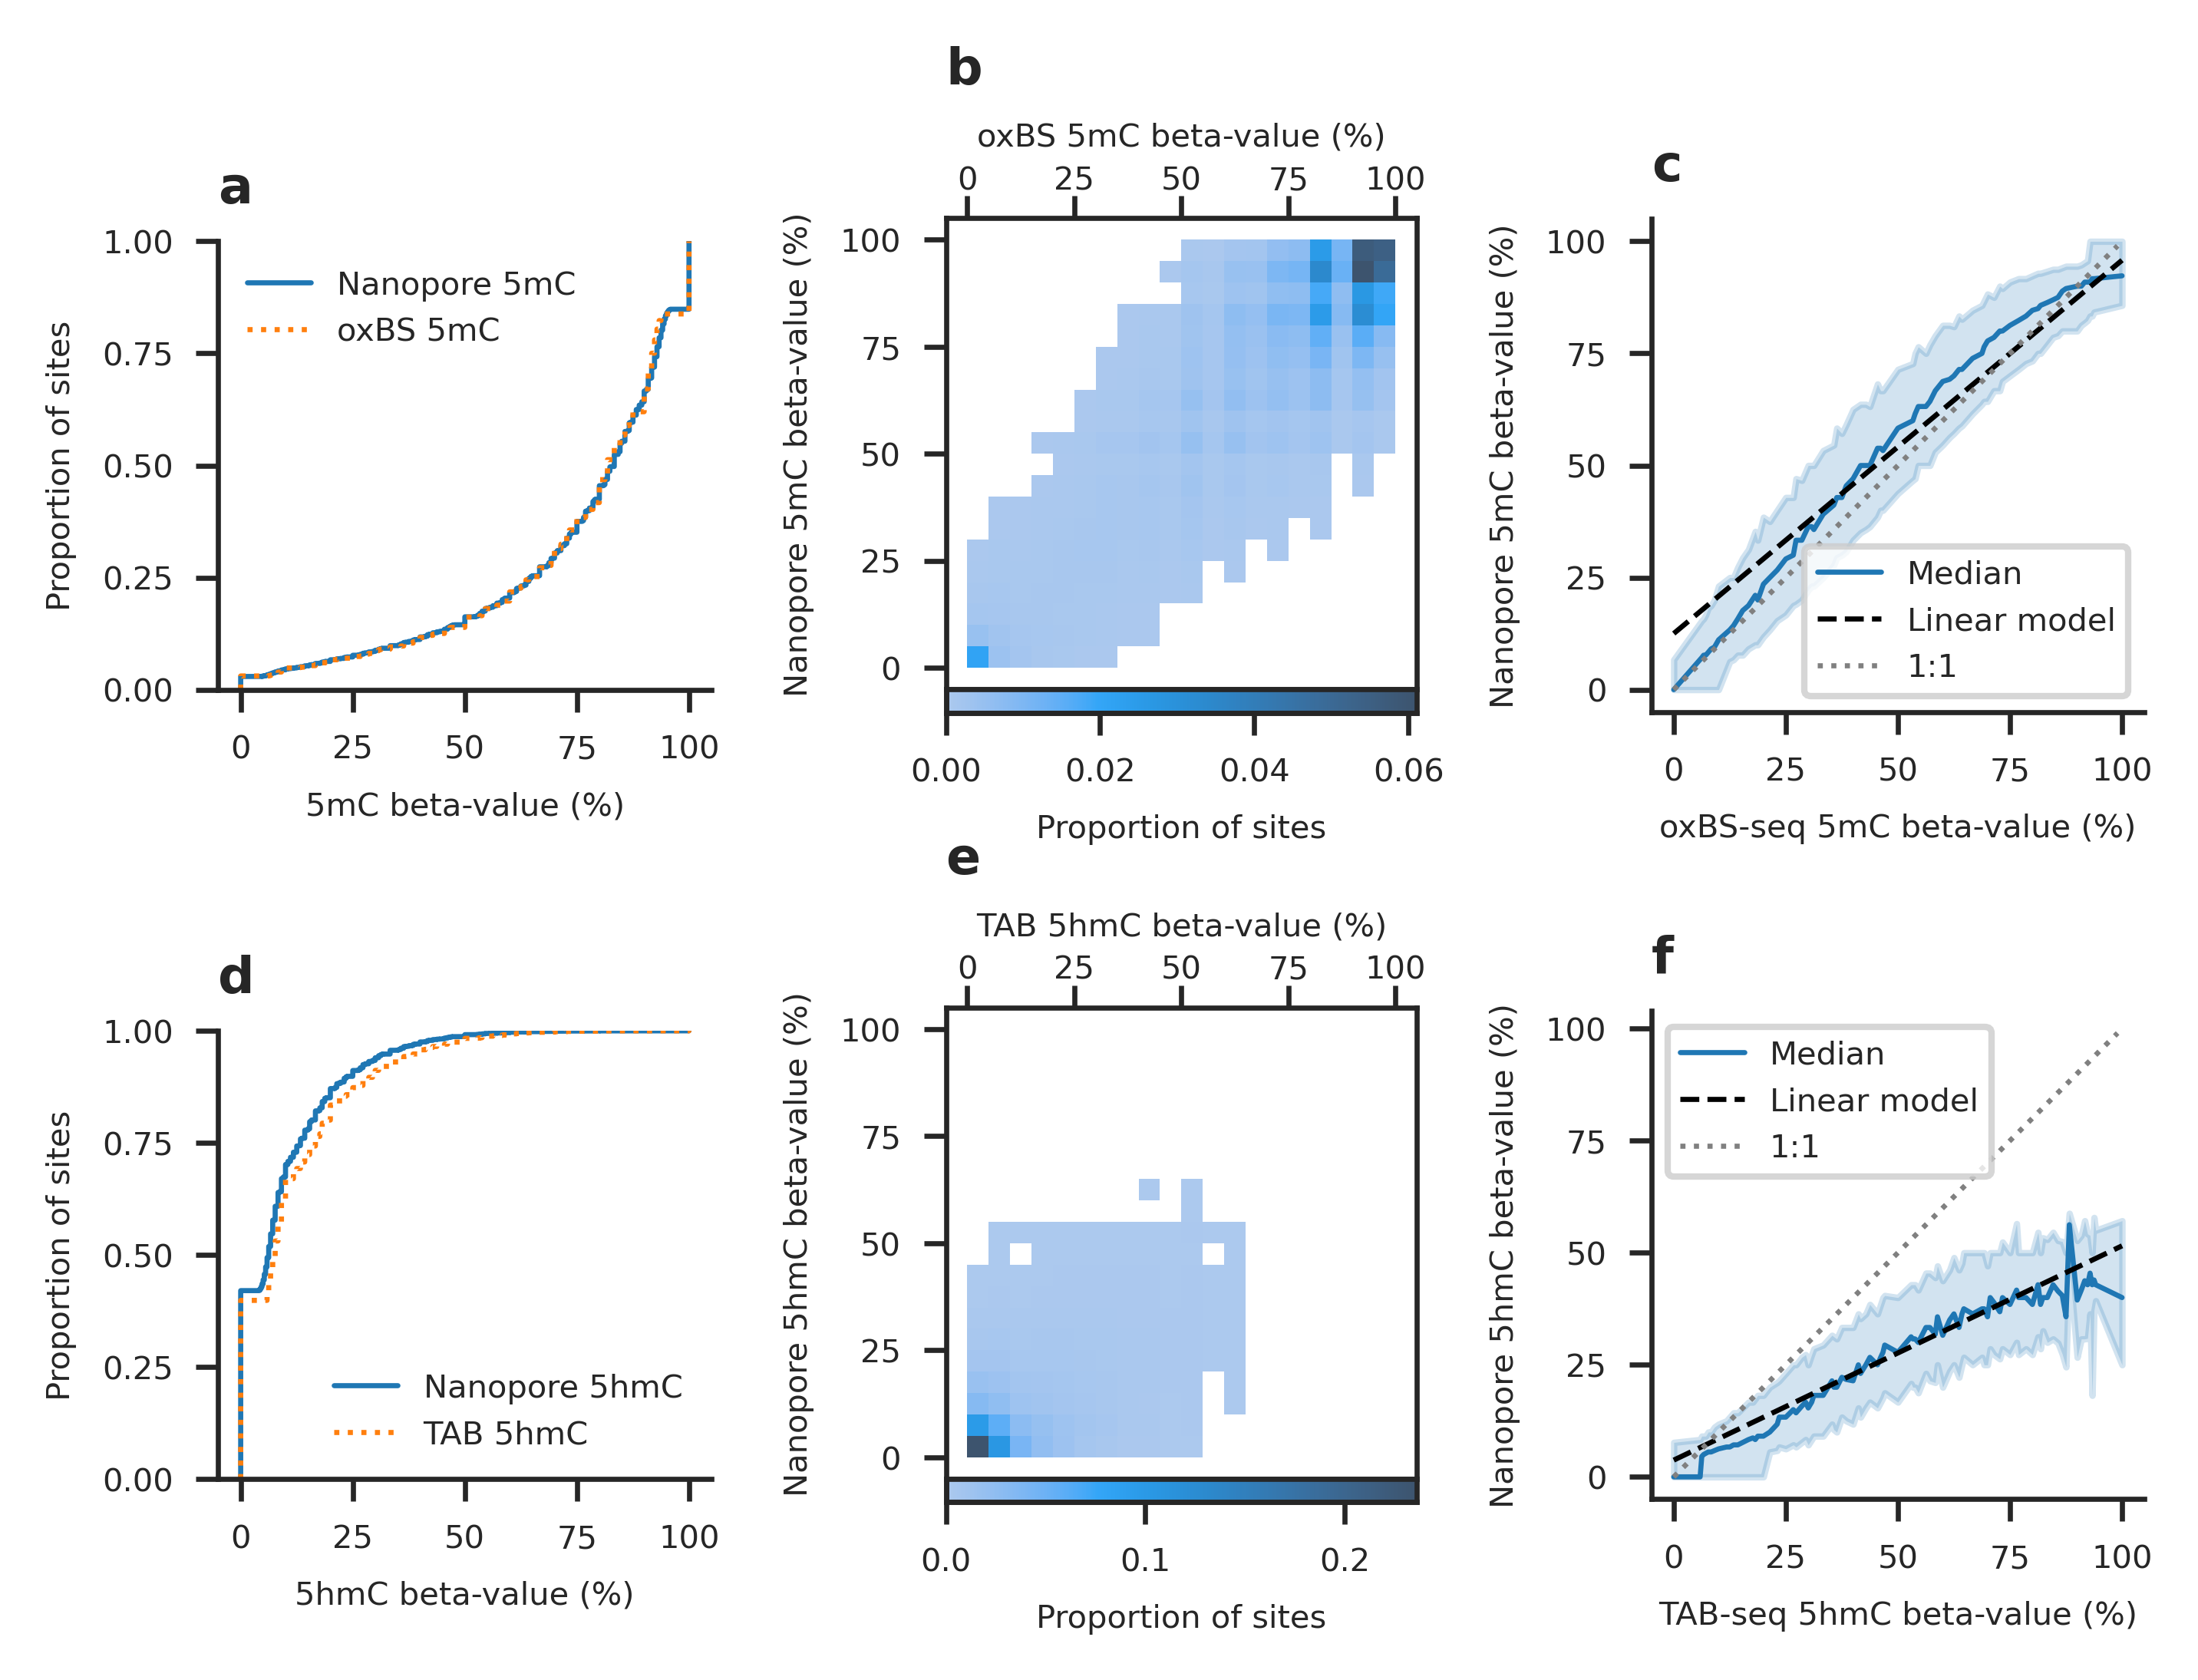

In [46]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn.preprocessing import Binarizer
from sklearn import metrics
from cycler import cycler
import string

sns.set_style("ticks")
mpl.rc('font', size=5)

fig, axes = plt.subplots(2, 3, figsize=(120/25.4, 89/25.4), dpi=600)

value_vars = [["percentMeth_5mC_Nanopore", "percentMeth_5mC_oxBS"], ["percentMeth_5hmC_Nanopore", "percentMeth_5hmC_TAB"]]
labels = [["Nanopore 5mC", "oxBS 5mC"], ["Nanopore 5hmC", "TAB 5hmC"]]

for df, value_var, label, row in zip([prom_oxbs_data, prom_tab_data], value_vars, labels, axes):
    # Col 1 # 
    ecdf = df.melt(
            id_vars=["Chromosome", "Start", "End"], 
            value_vars=value_var,
            value_name="percentMeth",
            var_name="method")
        
    ax1 = row[0]
    
    line_colors = list(sns.color_palette(n_colors=2).as_hex())
    for var, ls, c, label in zip(value_var, ["-", ":"], line_colors, label):
        sns.ecdfplot(ecdf.query(f"method == '{var}'"),
            x="percentMeth", lw=0.8, ls=ls, color=c, label=label, 
            ax=ax1)
           
    ax1.set_aspect(100)
    ax1.set_xticks(np.arange(0, 125, 25))
    ax1.set_yticks(np.arange(0, 1.25, 0.25))
    ax1.set_ylabel("Proportion of sites")
    
    # Col 2 # 
    ax2 = row[1]
    div = make_axes_locatable(ax2)
    cax = div.append_axes("bottom", size="5%", pad=0)

    sns.histplot(df, y=value_var[0], x=value_var[1], 
                 stat="proportion", pthresh=0.01, binwidth=5, cbar=True, 
                 cbar_kws={"label" : "Proportion of sites",
                           "pad" : 0, 
                           "orientation" : "horizontal",
                           "location" : "bottom"}, 
                 ax=ax2, cbar_ax=cax) 
    
    ax2.set_aspect("equal")
    ax2.tick_params(axis='x', which='major', pad=0)
    ax2.set_yticks(np.arange(0, 125, 25))
    ax2.set_xticks(np.arange(0, 125, 25))
    ax2.xaxis.tick_top()
    ax2.xaxis.set_label_position('top')

    # Col 3 # 
    ax3 = row[2]
    sns.lineplot(df, y=value_var[0], x=value_var[1], 
                 label="Median", estimator='median', errorbar=("pi", 50), lw=0.8, 
                 ax=ax3)
    sns.regplot(df, y=value_var[0], x=value_var[1], 
                 ci=None, color="black", line_kws={
                    "ls" : "--",
                    "lw" : 0.8
                }, label="Linear model", scatter=False, 
                ax=ax3)
    
    ax3.plot(np.arange(0, 100, 1), np.arange(0, 100, 1), c="grey", ls=":", lw=0.8, label="1:1")

    ax3.set_aspect("equal")
    ax3.set_xticks(np.arange(0, 125, 25))
    ax3.set_yticks(np.arange(0, 125, 25))
    ax3.legend()

# Ax formatting # 

axes = axes.flatten() 
for ax, letter in zip(axes, list(string.ascii_lowercase[:6])):
    ax.set_title(letter, loc="left", fontsize=8, fontweight="bold",)
    
axes[0].set_xlabel("5mC beta-value (%)")
axes[3].set_xlabel("5hmC beta-value (%)")
axes[0].legend(title=None, loc="upper left", frameon=False)
axes[3].legend(title=None, loc="lower right", frameon=False)
    
axes[1].set_xlabel("oxBS 5mC beta-value (%)", labelpad=3)
axes[1].set_ylabel("Nanopore 5mC beta-value (%)")
axes[4].set_xlabel("TAB 5hmC beta-value (%)", labelpad=3)
axes[4].set_ylabel("Nanopore 5hmC beta-value (%)")

axes[2].set_xlabel("oxBS-seq 5mC beta-value (%)")
axes[2].set_ylabel("Nanopore 5mC beta-value (%)")
axes[5].set_xlabel("TAB-seq 5hmC beta-value (%)")
axes[5].set_ylabel("Nanopore 5hmC beta-value (%)")

# Figure # 
sns.despine()

for ax in [axes[1], axes[4]]:
    sns.despine(ax=ax, top=False, right=False)

plt.gcf().set_size_inches(120/25.4, 89/25.4)

plt.tight_layout()
# plt.subplots_adjust(wspace=1.1, hspace=-0.1)
plt.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/CpG_level_sim.png", dpi=600)

In [ ]:
from sklearn.linear_model import LinearRegression
from scipy import stats

model = LinearRegression()

comparison = [["percentMeth_5mC_Nanopore", "percentMeth_5mC_Bisulphite"], ["percentMeth_5hmC_Nanopore", "percentMeth_5hmC_Bisulphite"]]

for comp in comparison:
    x = prom_comp_data[comp[1]].to_numpy().reshape(-1, 1)
    y = prom_comp_data[comp[0]].to_numpy().reshape(-1, 1)

    model.fit(x, y)
    print(f"Pearson: {stats.pearsonr(prom_comp_data[comp[0]], prom_comp_data[comp[1]])}")
    print(f"Model for {comp[0]} ~ {comp[1]}: {round(float(model.intercept_), 3)} + {round(float(model.coef_), 3)}X; R\N{SUPERSCRIPT TWO}={round(float(model.score(x, y)), 3)}")

## Differences

In [ ]:
import pandas as pd
prom_comp_data = pd.read_csv("./data_tables/prom_comp_data_10x.tsv")

In [ ]:
import seaborn as sns
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import Binarizer
from sklearn import metrics
from cycler import cycler

plt.figure(figsize=(89/25.4, 89/25.4), dpi=600)

sns.set_style("ticks")
mpl.rc('font', size=5)

ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 4), (0, 2), colspan=2)
ax3 = plt.subplot2grid((2, 4), (1, 1), colspan=2)

##### Row 1 #####
# Panel 1 and 2 # 

comparison = [["percentMeth_5mC_Nanopore", "percentMeth_5mC_Bisulphite"], ["percentMeth_5hmC_Nanopore", "percentMeth_5hmC_Bisulphite"]]

for index, ax in enumerate([ax1, ax2]):
    ax.plot(np.arange(0, 100, 1), np.arange(0, 100, 1), c="grey", ls=":", lw=0.8, label="Ideal 1:1")
    sns.lineplot(prom_comp_data, x=comparison[index][1], y=comparison[index][0], 
                 label="Median", estimator='median', errorbar=("pi", 50), lw=0.8, ax=ax)
    sns.regplot(prom_comp_data, x=comparison[index][1], y=comparison[index][0], 
                 ci=None, color="black", line_kws={
                    "ls" : "--",
                    "lw" : 0.8
                    }, label="Best fit", scatter=False, ax=ax)
    ax.set_aspect("equal")
    ax.set_xticks(np.arange(0, 125, 25))
    ax.set_yticks(np.arange(0, 125, 25))
    ax.legend()

ax1.set_xlabel("oxBS 5mC beta-value (%)")
ax1.set_ylabel("Nanopore 5mC beta-value (%)")
ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")

ax2.set_xlabel("TAB 5hmC beta-value (%)")
ax2.set_ylabel("Nanopore 5hmC beta-value (%)")
ax2.set_title("b", loc="left", fontsize=8, fontweight="bold")

##### Row 2 #####
# Panel 3 # 

div = make_axes_locatable(ax3)
cax = div.append_axes("right", size="5%", pad=0)

true, pred = prom_comp_data["percentMeth_5hmC_Bisulphite"].to_numpy().reshape((-1, 1)), prom_comp_data["percentMeth_5hmC_Nanopore"].to_numpy().reshape((-1, 1))

binarizer = Binarizer(threshold=0)
true_b, pred_b = binarizer.fit_transform(true), binarizer.fit_transform(pred)
cm = metrics.ConfusionMatrixDisplay.from_predictions(
    true_b, pred_b, 
    display_labels=["5hmC \nAbsent", "5hmC \nPresent"], 
    normalize="all", 
    colorbar=False, cmap="Blues", 
    im_kw={"origin" : "lower"}, 
    values_format=".2f",
    ax=ax3)

plt.colorbar(cm.im_, cax, label="As proportion of TAB")
ax3.grid(False)
ax3.set_xlabel("Nanopore 5hmC")
ax3.set_ylabel("TAB 5hmC")
ax3.set_title("c", loc="left", fontsize=8, fontweight="bold")

sns.despine()
sns.despine(ax=ax3, top=False)

plt.gcf().set_size_inches(89/25.4, 89/25.4)
plt.subplots_adjust(wspace=0.8, hspace=0.5)
# plt.tight_layout()
plt.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/CpG_level_dif.png", dpi=600)

# Macro-level 5hmC comparison

In [1]:
import pandas as pd
from MultisiteTools import *
from common import *

nano_path = "/mnt/data1/doh28/data/prom_R10.4.1_E8.2_WGS_brain_DH/dorado_0.3.2_basecalls/modbases/cbm1_prom_modbases_mapq60.bed"
tab_path = "/mnt/data1/doh28/data/CRR008807_TAB/mapq_filtered/modified_bases/CRR008807_TAB_merged_resorted_q10.bedGraph.gz.bismark.zero.cov"
    
prom_tab_comp = makeCpGRange(nano_path, tab_path)

Changing colnames to be PyRanges compatible...
Done
Changing colnames to be PyRanges compatible...
Done


In [2]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=FutureWarning)
    all_features = prom_tab_comp.group_by_annotation("features", "./feature_references/genic/").enrichment_over_mean(include_zeros=True).df
    all_cgi = prom_tab_comp.group_by_annotation("CGI", "./feature_references/cgi/").enrichment_over_mean(include_zeros=True).df
    all_genes = prom_tab_comp.group_by_annotation("genes", "./feature_references/genes/EncodeGencodeBasicVM32_Genes.bed").enrichment_over_mean(include_zeros=True).df

features_genes_cgi = pd.concat([all_features, all_cgi, all_genes])

Aggregating all of ['percentMeth_5hmC_Nanopore', 'percentMeth_5hmC_TAB']
Aggregating all of ['percentMeth_5hmC_Nanopore', 'percentMeth_5hmC_TAB']
Aggregating all of ['percentMeth_5hmC_Nanopore', 'percentMeth_5hmC_TAB']


In [3]:
features_genes_cgi = features_genes_cgi.query("log2enrichment_5hmC_TAB > -inf & log2enrichment_5hmC_Nanopore > -inf")
all_hists = features_genes_cgi.replace(["3UTR", "5UTR", "Genes", "CGI"], ["Exon", "Exon", "Gene body", "CpG island"])
all_hists = all_hists.query("feature_type != 'Intergenic' & feature_type != 'Open sea' & feature_type != 'Shore' & feature_type != 'Shelf'")

In [4]:
def replaceDecorator(func):
    def renameWrapper(*args, **kwargs):
        return func(*args, **kwargs).replace(["Bisulphite"], ["TAB"], errors="ignore")
    return renameWrapper

@replaceDecorator
def replacePivoter(df):
    return annotationPivot(df)

In [5]:
genic_df = features_genes_cgi.query("feature_type != 'Intergenic' & feature_type != 'Genes' & feature_type != 'Open sea' & feature_type != 'Shore' & feature_type != 'Shelf' & feature_type != 'CGI'")
cgi_df = features_genes_cgi.query("feature_type == 'CGI' | feature_type == 'Shelf' | feature_type == 'Shore'").replace("CGI", "Island")

genic_barplot_df, cgi_barplot_df = map(annotationPivot, [genic_df, cgi_df])

## Figure

In [ ]:
rows= 5
ax1 = plt.subplot2grid((rows, 6), (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((rows, 6), (0, 2), colspan=2, rowspan=2)
ax3 = plt.subplot2grid((rows, 6), (0, 4), colspan=2, rowspan=2)
ax4 = plt.subplot2grid((rows, 6), (2, 0), colspan=2, rowspan=2)
ax5 = plt.subplot2grid((rows, 6), (2, 2), colspan=2, rowspan=2)
ax6 = plt.subplot2grid((rows, 6), (2, 4), colspan=2, rowspan=2)
ax7 = plt.subplot2grid((rows, 6), (4, 0), colspan=3, rowspan=1)
ax8 = plt.subplot2grid((rows, 6), (4, 4), colspan=2, rowspan=1)

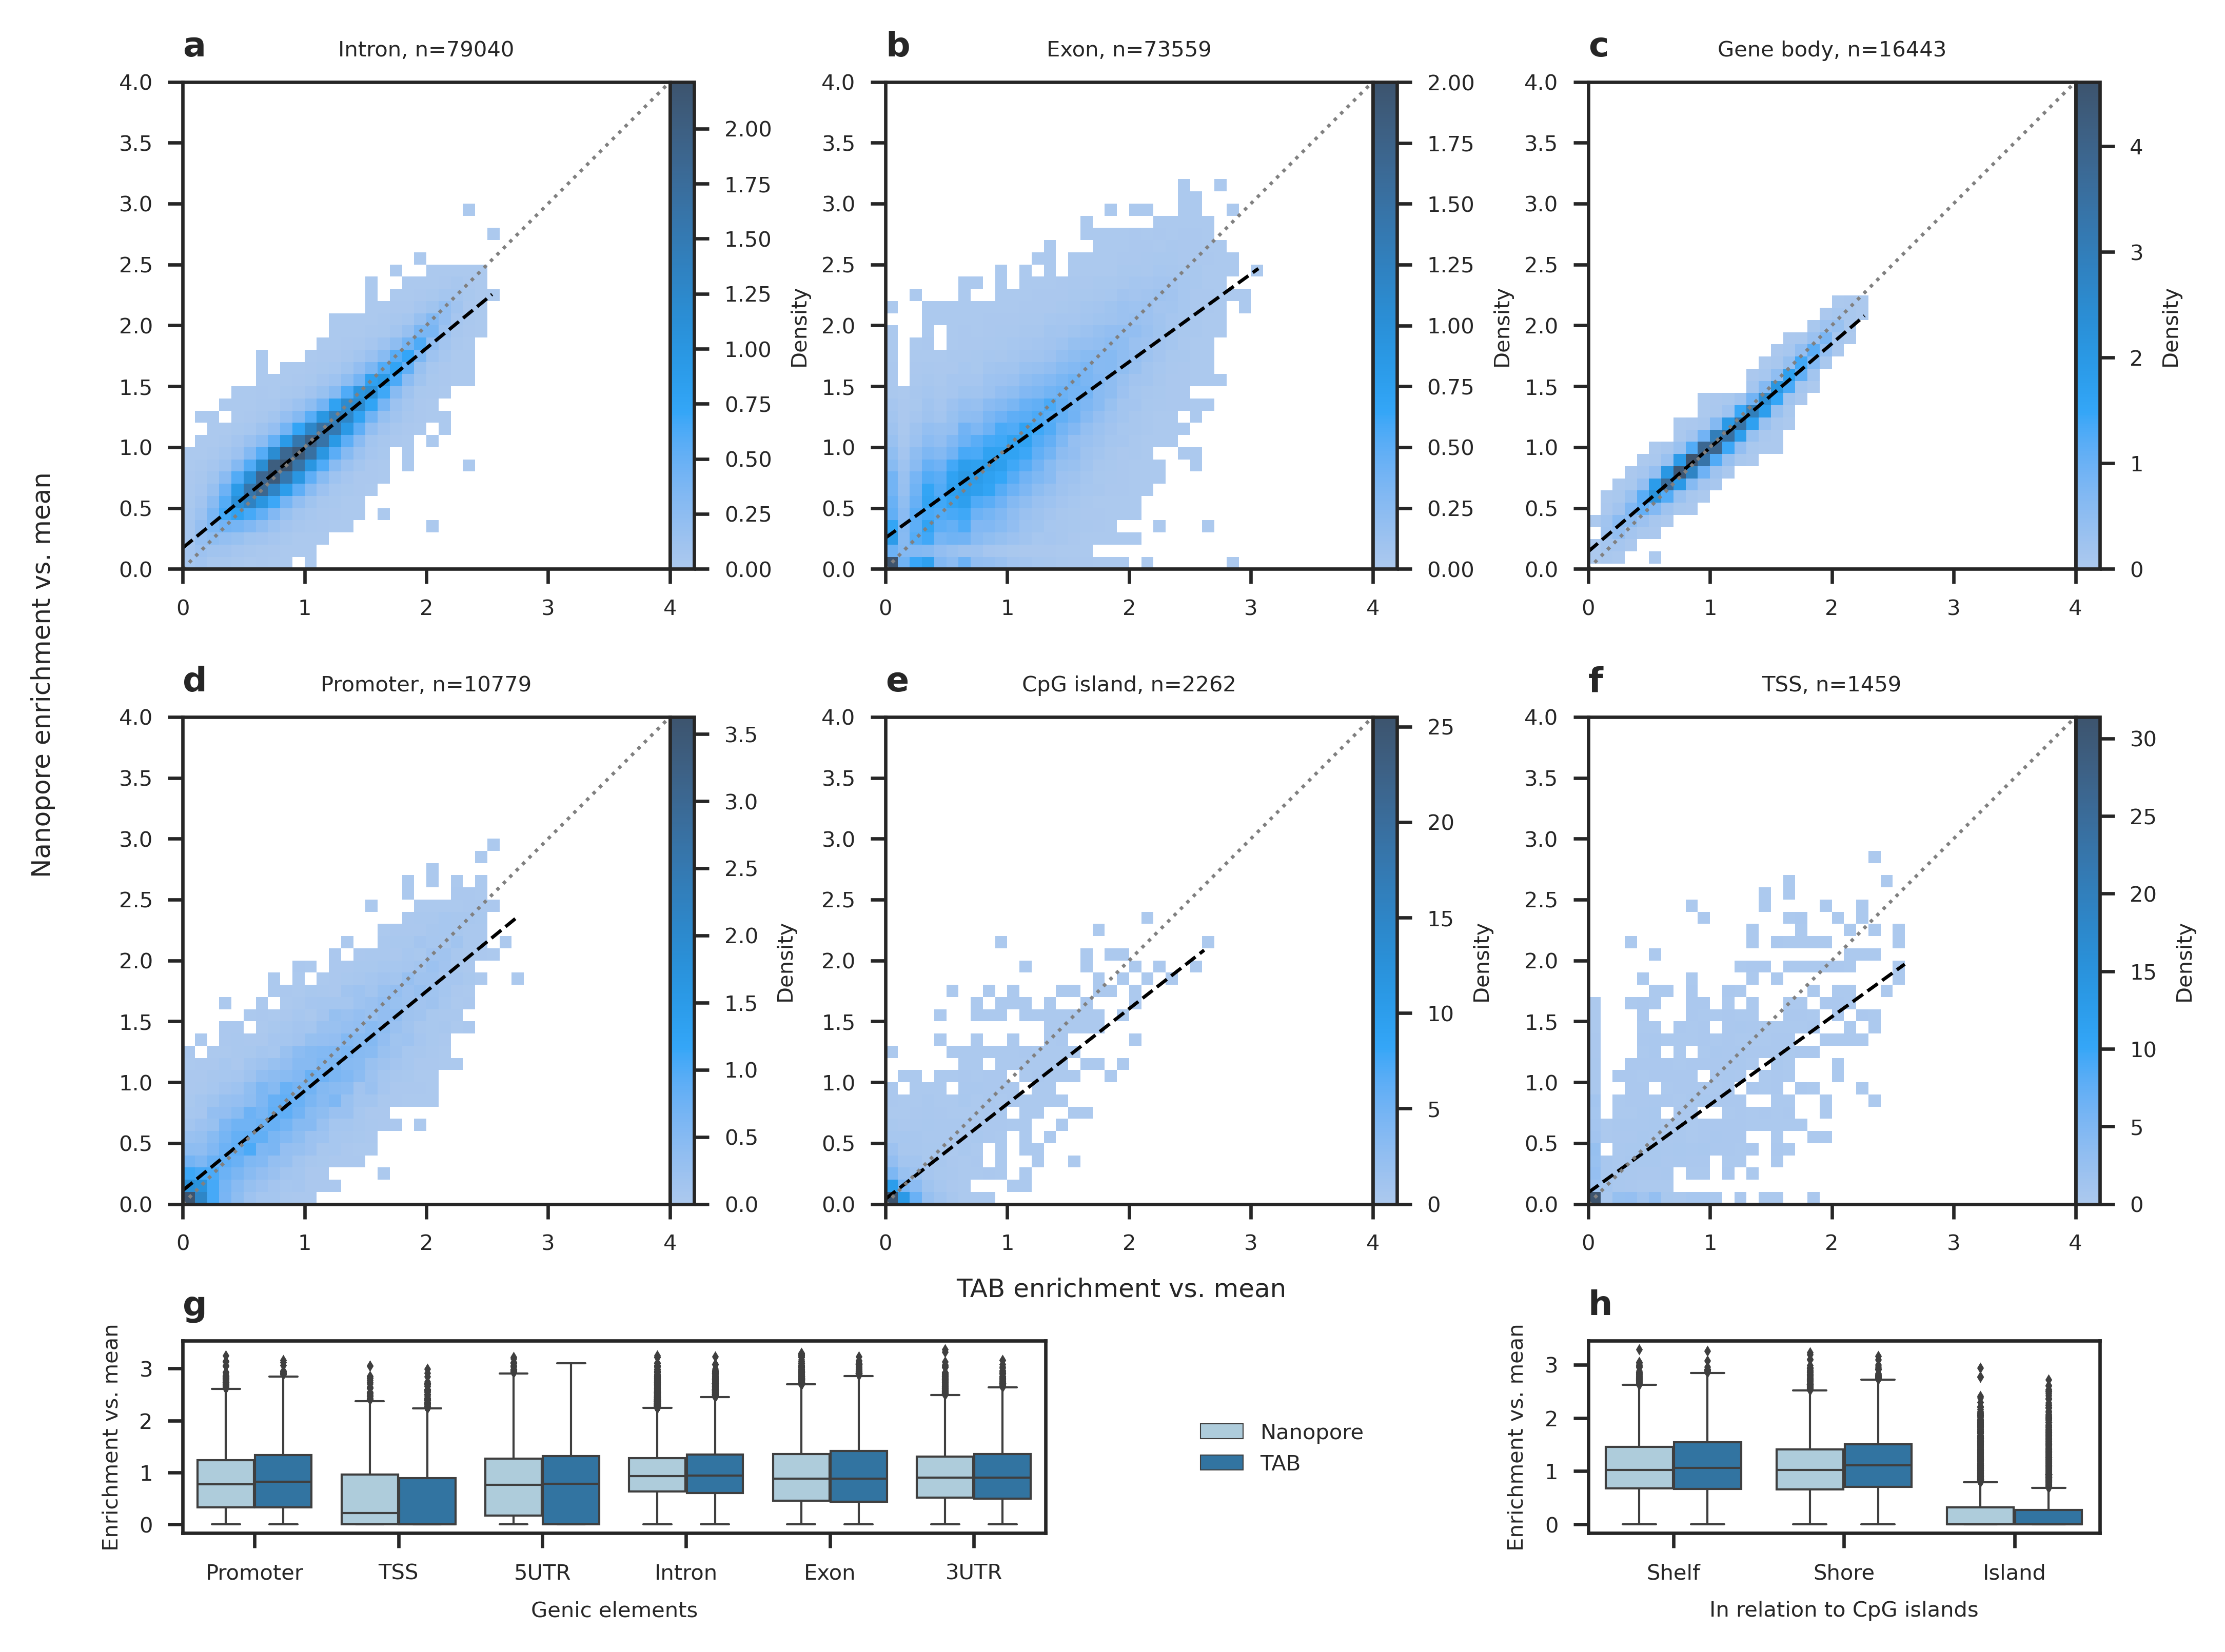

In [6]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set_style("ticks")

fig = plt.figure(figsize=(180/25.4, 140/25.4), dpi=600)
mpl.rc('font', size=5)

rows = 5

ax1 = plt.subplot2grid((rows, 6), (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((rows, 6), (0, 2), colspan=2, rowspan=2)
ax3 = plt.subplot2grid((rows, 6), (0, 4), colspan=2, rowspan=2)
ax4 = plt.subplot2grid((rows, 6), (2, 0), colspan=2, rowspan=2)
ax5 = plt.subplot2grid((rows, 6), (2, 2), colspan=2, rowspan=2)
ax6 = plt.subplot2grid((rows, 6), (2, 4), colspan=2, rowspan=2)
ax7 = plt.subplot2grid((rows, 6), (4, 0), colspan=3)
ax8 = plt.subplot2grid((rows, 6), (4, 4), colspan=2)

hist_axes = [ax1, ax2, ax3, ax4, ax5, ax6]
ax_titles = ["a", "b", "c", "d", "e", "f"]
feature_order = ["Intron", "Exon", "Gene body", "Promoter", "CpG island", "TSS"]

for i, feature_type in enumerate(feature_order):
    div = make_axes_locatable(hist_axes[i])
    cax = div.append_axes("right", size="5%", pad=0)

    hist_df = all_hists.query(f"feature_type == '{feature_type}'")
    cpg_count_median = hist_df["CpG_count"].quantile(0.50)
    hist_df = hist_df.query(f"CpG_count >= {cpg_count_median} & CpG_count > 1")

    sns.histplot(hist_df, x="log2enrichment_5hmC_TAB", y="log2enrichment_5hmC_Nanopore", 
                 binwidth=0.1, cbar=True, stat="density", cbar_kws={"label" : "Density", "pad" : 0},
                 cbar_ax=cax, ax=hist_axes[i])
    
    sns.regplot(hist_df, x="log2enrichment_5hmC_TAB", y="log2enrichment_5hmC_Nanopore", 
                 scatter=False, ci=None, color="black", 
                 line_kws={"ls" : "--", "lw" : 0.8},
                 x_ci=None, robust=True,
                 ax=hist_axes[i])

    hist_axes[i].set_aspect("equal")
    hist_axes[i].set_ylabel(None)
    hist_axes[i].set_xlabel(None)
    # hist_axes[i].set_ylabel("Nanopore enrichment\nvs. mean")
    # hist_axes[i].set_xlabel("TAB-seq enrichment vs. mean")
    hist_axes[i].set_ylim((0, 4))
    hist_axes[i].set_xlim((0, 4))

    hist_axes[i].set_xticks(ticks=range(0, 5, 1))

    # ax.axhline(0, ls=":", lw=0.8, c="grey")
    # ax.axvline(0, ls=":", lw=0.8, c="grey")

    hist_axes[i].plot((0, 5), (0, 5), ls=":", lw=0.8, c="grey")
    hist_axes[i].set_title(f"{feature_order[i]}, n={len(hist_df)}", loc="center", fontsize=5)
    hist_axes[i].set_title(f"{ax_titles[i]}", loc="left", fontsize=8, fontweight="bold")

genic_barplot_df["feature_type"] = pd.Categorical(genic_barplot_df["feature_type"], 
                                                  ["Promoter", "TSS", "5UTR", "Intron", "Exon", "3UTR"])
cgi_barplot_df["feature_type"] = pd.Categorical(cgi_barplot_df["feature_type"],
                                                ["Shelf", "Shore", "Island"])
barplots = [genic_barplot_df, cgi_barplot_df]

for i, ax in enumerate([ax7, ax8]):
    df = barplots[i]
    sns.boxplot(df, x="feature_type", y="log2enrichment_5hmC", 
                hue="method", palette="Paired", dodge=True, linewidth=0.5,
                showfliers=True, fliersize=0.5,
                ax=ax)
    ax.set_title(f"{['g', 'h'][i]}", loc="left", fontsize=8, fontweight="bold")
    ax.set_xlabel(f"{['Genic elements', 'In relation to CpG islands'][i]}")
    ax.set_ylabel("Enrichment vs. mean")
    ax.get_legend().set_visible(False)

barplot_handles, barplot_labels = ax7.get_legend_handles_labels()

fig.legend(barplot_handles, barplot_labels, bbox_to_anchor=(.62, .17), frameon=False)

fig.supylabel("Nanopore enrichment vs. mean", x=0, y=.6)
fig.supxlabel("TAB enrichment vs. mean", x=.5, y=.23)

fig.tight_layout()
fig.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/macro_level_analysis_including_zeros.png", dpi=600)

## Stats

In [13]:
from sklearn.linear_model import LinearRegression
from scipy import stats

model = LinearRegression()

feature_order = ["Intron", "Exon", "Gene body", "Promoter", "TSS", "CpG island"]
feature_list = []
for i, feature_type in enumerate(feature_order):
    hist_df = all_hists.query(f"feature_type == '{feature_type}'")
    cpg_count_median = hist_df["CpG_count"].quantile(0.50)
    hist_df = hist_df.query(f"CpG_count >= {cpg_count_median} & CpG_count > 1")
    
    new_median = hist_df["CpG_count"].min()
    x, y = hist_df["log2enrichment_5hmC_TAB"], hist_df["log2enrichment_5hmC_Nanopore"]

    x_np, y_np = x.to_numpy().reshape(-1, 1), y.to_numpy().reshape(-1, 1)

    def statistic(x, y, axis):
        return np.mean(x, axis=axis) - np.mean(y, axis=axis)

    model.fit(x_np, y_np)

    # print(f"{feature_type}: {new_median}, {len(hist_df)}")
    # print(f"Pearson: {stats.pearsonr(x, y)}; Spearman: {stats.spearmanr(x, y)}")
    # print(f"Y = {model.coef_}x + {model.intercept_}, {model.score(x_np, y_np)}")

    if len(hist_df) <= 20000:
        test = "Permutation"
        pvalue = stats.permutation_test([x, y], statistic).pvalue
    else:
        test = "T-Test"
        pvalue = stats.ttest_ind(x, y).pvalue

    feature_list.append([feature_type, round(stats.pearsonr(x, y).statistic, 3), round(stats.spearmanr(x, y).statistic, 3), f"Y = {round(float(model.coef_), 3)}x + {round(float(model.intercept_), 3)}, {round(model.score(x_np, y_np), 3)}", round(pvalue, 3)])
all_feature_stats = pd.DataFrame(feature_list)
all_feature_stats.columns = ['Feature', 'Pearson', 'Spearman', 'Linear function', 'Test']
all_feature_stats

Feature  Pearson  Spearman            Linear function   Test
0      Intron    0.910     0.894   Y = 0.82x + 0.172, 0.828  0.000
1        Exon    0.748     0.719    Y = 0.71x + 0.271, 0.56  0.007
2   Gene body    0.974     0.971  Y = 0.853x + 0.144, 0.949  0.003
3    Promoter    0.867     0.858  Y = 0.814x + 0.124, 0.751  0.000
4         TSS    0.713     0.636  Y = 0.705x + 0.156, 0.509  0.567
5  CpG island    0.760     0.432  Y = 0.749x + 0.068, 0.577  0.543

In [ ]:
from sklearn.linear_model import LinearRegression
from scipy import stats

model = LinearRegression()

feature_order = ["Intron", "Exon", "Gene body", "Promoter", "TSS", "CpG island"]

for i, feature_type in enumerate(feature_order):
    hist_df = all_hists.query(f"feature_type == '{feature_type}'")
    cpg_count_median = hist_df["CpG_count"].quantile(0.50)
    hist_df = hist_df.query(f"CpG_count >= {cpg_count_median} & CpG_count > 1")
    
    new_median = hist_df["CpG_count"].min()
    x, y = hist_df["log2enrichment_5hmC_TAB"], hist_df["log2enrichment_5hmC_Nanopore"]

    x_np, y_np = x.to_numpy().reshape(-1, 1), y.to_numpy().reshape(-1, 1)

    def statistic(x, y, axis):
        return np.mean(x, axis=axis) - np.mean(y, axis=axis)

    model.fit(x_np, y_np)

    print(f"{feature_type}: {new_median}, {len(hist_df)}")
    print(f"Pearson: {stats.pearsonr(x, y)}; Spearman: {stats.spearmanr(x, y)}")
    print(f"Y = {model.coef_}x + {model.intercept_}, {model.score(x_np, y_np)}")
    if len(hist_df) <= 4000:
        print(f"Permutation: {stats.permutation_test([x, y], statistic).pvalue}")
    else:
        print(f"T-Test independent: {stats.ttest_ind(x, y).pvalue}")

In [ ]:
for feature_type in list(all_hists["feature_type"].unique()):
    hist_df = all_hists.query(f"feature_type == '{feature_type}'")
    cpg_count_median = hist_df["CpG_count"].quantile(0.25)
    hist_df = hist_df.query(f"CpG_count >= {cpg_count_median}")
    print(feature_type, cpg_count_median, len(hist_df))


In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

comparison =[all_genes.query("CpG_count >= 10"), all_features.query("CpG_count >= 2 & feature_type == 'Promoter'")]

for comp in comparison:
    x = comp["log2enrichment_5hmC_Bisulphite"].to_numpy().reshape(-1, 1)
    y = comp["log2enrichment_5hmC_Nanopore"].to_numpy().reshape(-1, 1)

    model.fit(x, y)
    print(f"Model: {round(float(model.intercept_), 3)} + {round(float(model.coef_), 3)}X; R\N{SUPERSCRIPT TWO}={round(float(model.score(x, y)), 3)}")

# Macro level 5mC comparison

In [15]:
import pandas as pd
from MultisiteTools import *
from common import *
import warnings

nano_path = "/mnt/data1/doh28/data/prom_R10.4.1_E8.2_WGS_brain_DH/dorado_0.3.2_basecalls/modbases/cbm1_prom_modbases_mapq60.bed"
oxbs_path = "/mnt/data1/doh28/data/CRR008808_oxBS/extraction_output/mapq_filter/CRR008808_oxBS_merged.bedGraph.gz.bismark.zero.cov"

prom_oxbs_comp = makeCpGRange(nano_path, oxbs_path, "5mC")

with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=FutureWarning)
    all_features = prom_oxbs_comp.group_by_annotation("features", "./feature_references/genic/").enrichment_over_mean(include_zeros=True).df
    all_cgi = prom_oxbs_comp.group_by_annotation("CGI", "./feature_references/cgi/").enrichment_over_mean(include_zeros=True).df
    all_genes = prom_oxbs_comp.group_by_annotation("genes", "./feature_references/genes/EncodeGencodeBasicVM32_Genes.bed").enrichment_over_mean(include_zeros=True).df

features_genes_cgi = pd.concat([all_features, all_cgi, all_genes])

Changing colnames to be PyRanges compatible...
Done
Changing colnames to be PyRanges compatible...
Done
Aggregating all of ['percentMeth_5mC_Nanopore', 'percentMeth_5mC_oxBS']
Aggregating all of ['percentMeth_5mC_Nanopore', 'percentMeth_5mC_oxBS']
Aggregating all of ['percentMeth_5mC_Nanopore', 'percentMeth_5mC_oxBS']


In [16]:
features_genes_cgi = features_genes_cgi.query("log2enrichment_5mC_oxBS > -inf & log2enrichment_5mC_Nanopore > -inf")
all_hists = features_genes_cgi.replace(["3UTR", "5UTR", "Genes", "CGI"], ["Exon", "Exon", "Gene body", "CpG island"])
all_hists = all_hists.query("feature_type != 'Intergenic' & feature_type != 'Open sea' & feature_type != 'Shore' & feature_type != 'Shelf'")

genic_df = features_genes_cgi.query("feature_type != 'Intergenic' & feature_type != 'Genes' & feature_type != 'Open sea' & feature_type != 'Shore' & feature_type != 'Shelf' & feature_type != 'CGI'")
cgi_df = features_genes_cgi.query("feature_type == 'CGI' | feature_type == 'Shelf' | feature_type == 'Shore'").replace("CGI", "Island")

genic_barplot_df, cgi_barplot_df = map(annotationPivot, [genic_df, cgi_df])

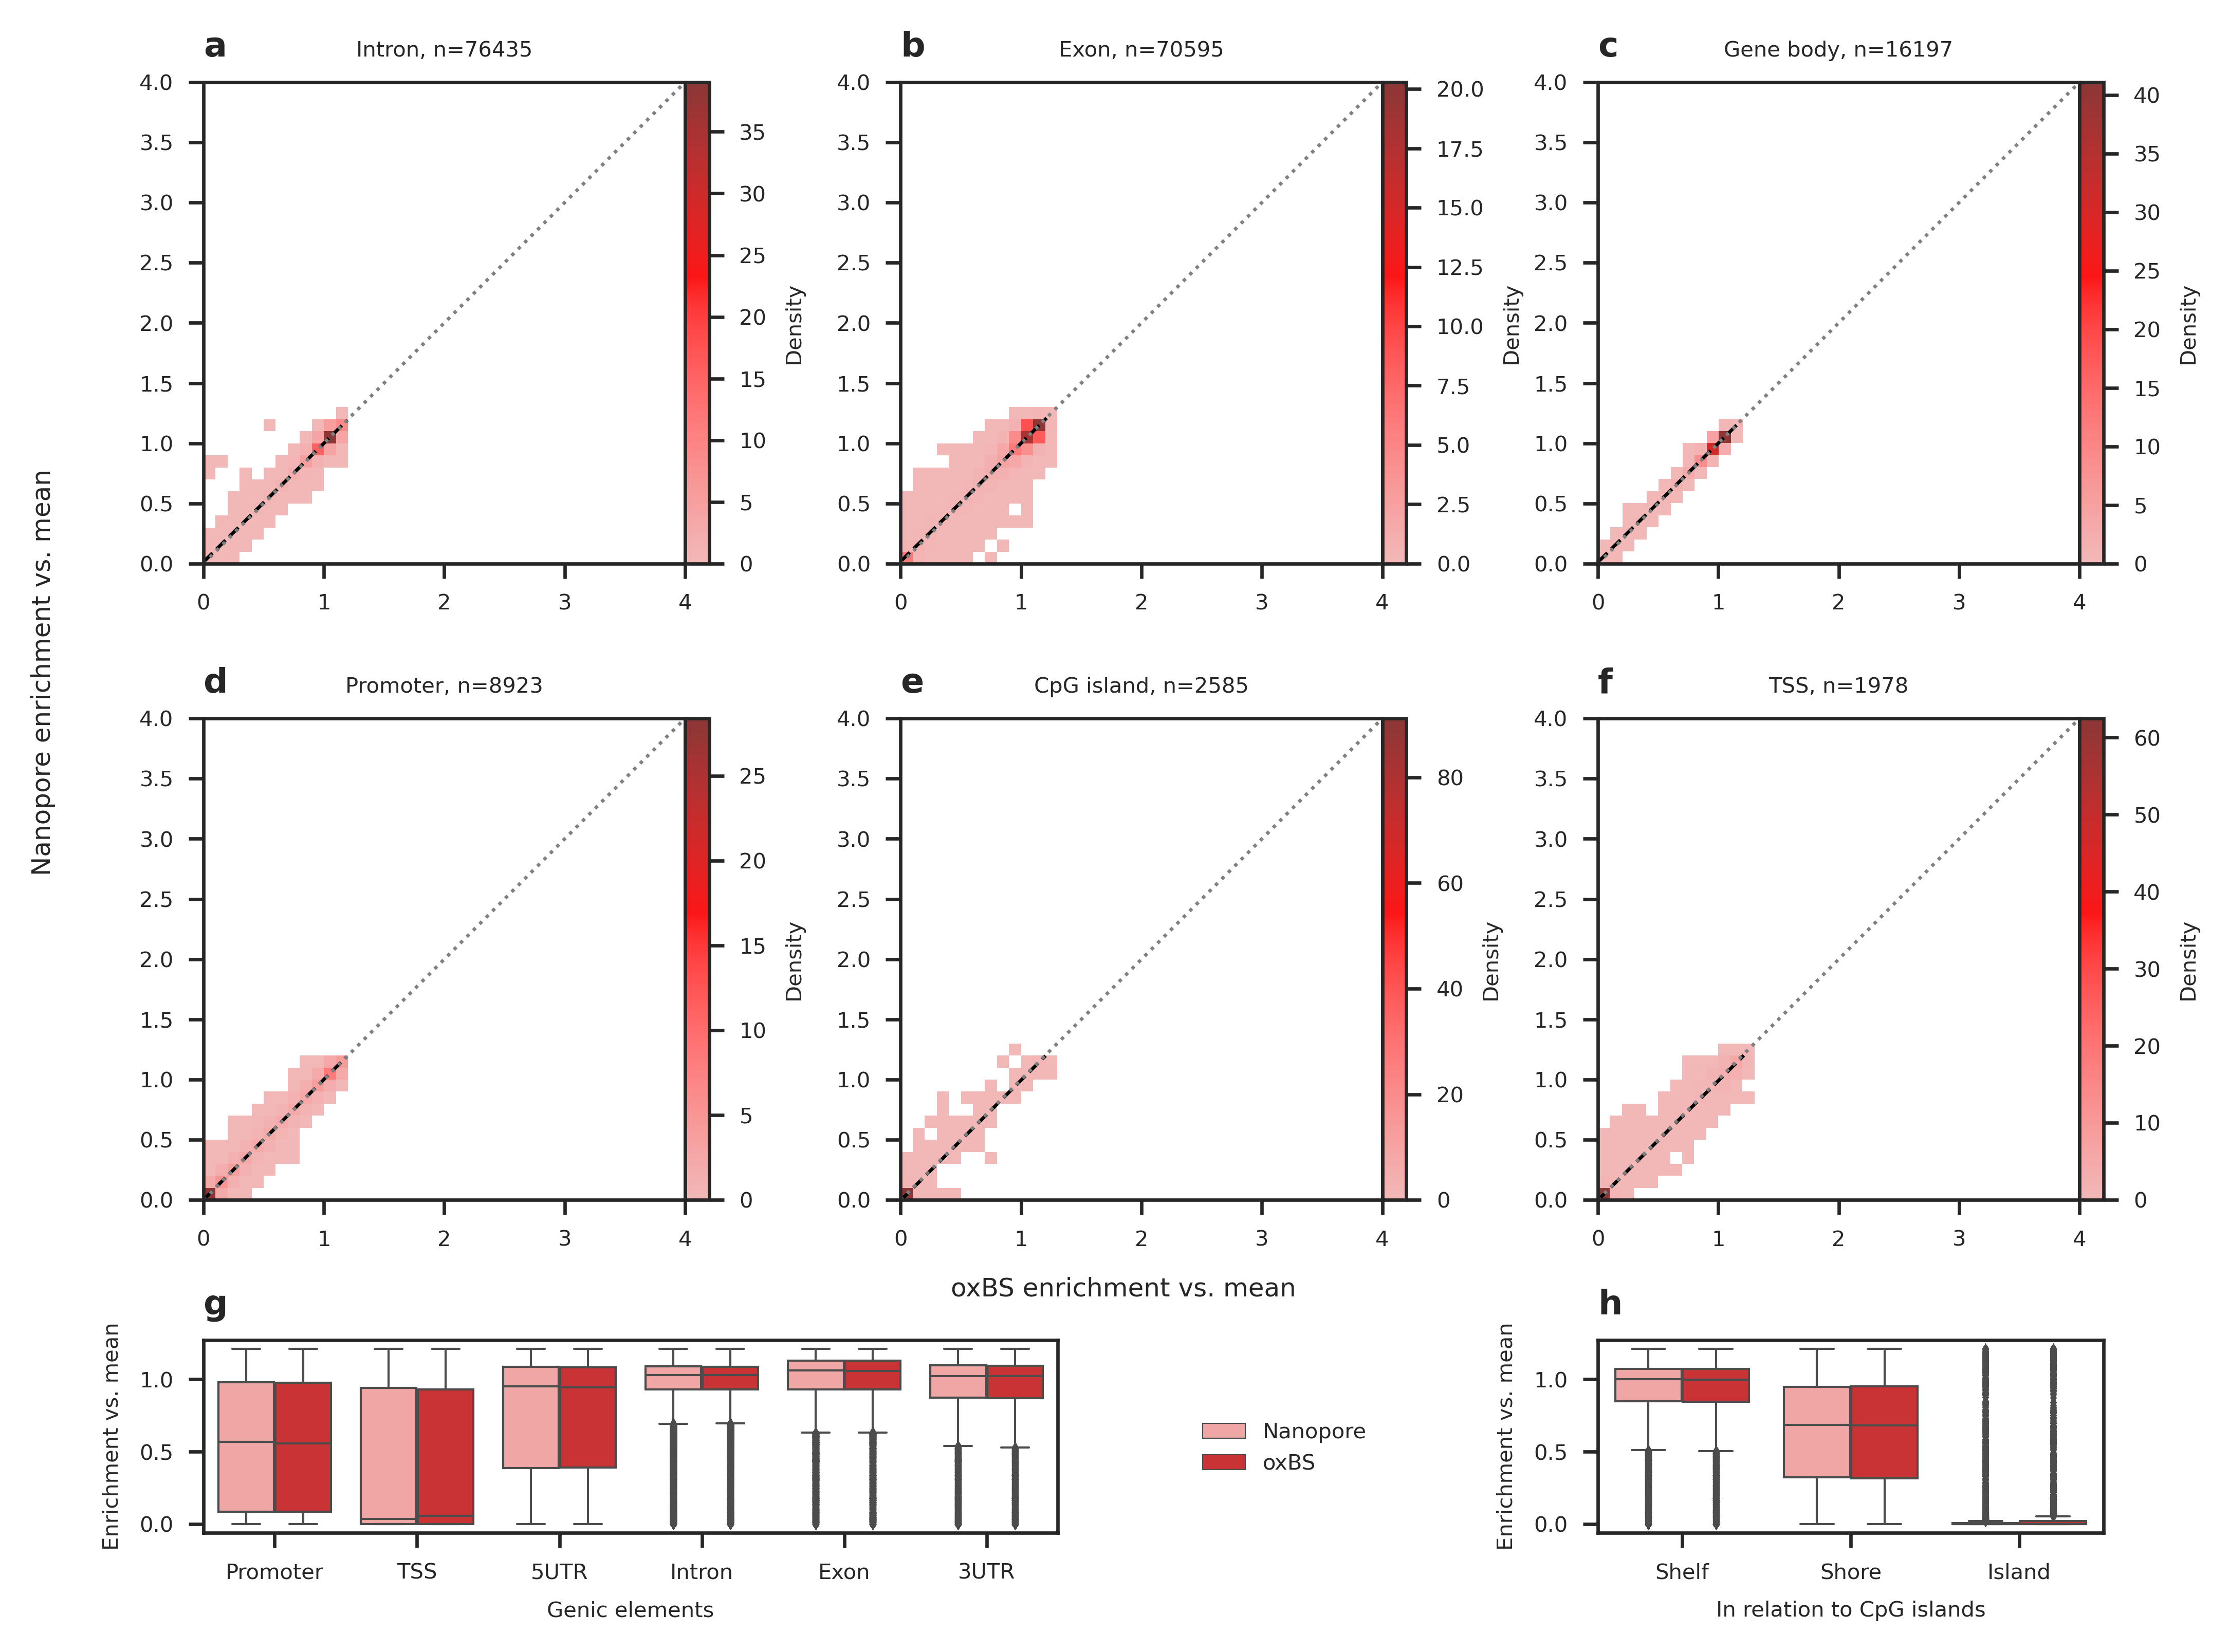

In [17]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set_style("ticks")

fig = plt.figure(figsize=(180/25.4, 140/25.4), dpi=600)
mpl.rc('font', size=5)

rows = 5

ax1 = plt.subplot2grid((rows, 6), (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((rows, 6), (0, 2), colspan=2, rowspan=2)
ax3 = plt.subplot2grid((rows, 6), (0, 4), colspan=2, rowspan=2)
ax4 = plt.subplot2grid((rows, 6), (2, 0), colspan=2, rowspan=2)
ax5 = plt.subplot2grid((rows, 6), (2, 2), colspan=2, rowspan=2)
ax6 = plt.subplot2grid((rows, 6), (2, 4), colspan=2, rowspan=2)
ax7 = plt.subplot2grid((rows, 6), (4, 0), colspan=3)
ax8 = plt.subplot2grid((rows, 6), (4, 4), colspan=2)

hist_axes = [ax1, ax2, ax3, ax4, ax5, ax6]
ax_titles = ["a", "b", "c", "d", "e", "f"]
feature_order = ["Intron", "Exon", "Gene body", "Promoter", "CpG island", "TSS"]

for i, feature_type in enumerate(feature_order):
    div = make_axes_locatable(hist_axes[i])
    cax = div.append_axes("right", size="5%", pad=0)

    hist_df = all_hists.query(f"feature_type == '{feature_type}'")
    cpg_count_median = hist_df["CpG_count"].quantile(0.50)
    hist_df = hist_df.query(f"CpG_count >= {cpg_count_median} & CpG_count > 1")

    sns.histplot(hist_df, x="log2enrichment_5mC_oxBS", y="log2enrichment_5mC_Nanopore", 
                 binwidth=0.1, cbar=True, stat="density", cbar_kws={"label" : "Density", "pad" : 0},
                 color="red",
                 cbar_ax=cax, ax=hist_axes[i])
    
    sns.regplot(hist_df, x="log2enrichment_5mC_oxBS", y="log2enrichment_5mC_Nanopore", 
                 scatter=False, ci=None, color="black", 
                 line_kws={"ls" : "--", "lw" : 0.8},
                 x_ci=None, robust=True,
                 ax=hist_axes[i])

    hist_axes[i].set_aspect("equal")
    hist_axes[i].set_ylabel(None)
    hist_axes[i].set_xlabel(None)
    hist_axes[i].set_ylim((0, 4))
    hist_axes[i].set_xlim((0, 4))

    hist_axes[i].set_xticks(ticks=range(0, 5, 1))

    hist_axes[i].plot((0, 5), (0, 5), ls=":", lw=0.8, c="grey")
    hist_axes[i].set_title(f"{feature_order[i]}, n={len(hist_df)}", loc="center", fontsize=5)
    hist_axes[i].set_title(f"{ax_titles[i]}", loc="left", fontsize=8, fontweight="bold")

genic_barplot_df["feature_type"] = pd.Categorical(genic_barplot_df["feature_type"], 
                                                  ["Promoter", "TSS", "5UTR", "Intron", "Exon", "3UTR"])
cgi_barplot_df["feature_type"] = pd.Categorical(cgi_barplot_df["feature_type"],
                                                ["Shelf", "Shore", "Island"])
barplots = [genic_barplot_df, cgi_barplot_df]

for i, ax in enumerate([ax7, ax8]):
    df = barplots[i]
    sns.boxplot(df, x="feature_type", y="log2enrichment_5mC", 
                hue="method", palette=sns.color_palette("Paired")[4:6], dodge=True, linewidth=0.5,
                showfliers=True, fliersize=0.5,
                ax=ax)
    ax.set_title(f"{['g', 'h'][i]}", loc="left", fontsize=8, fontweight="bold")
    ax.set_xlabel(f"{['Genic elements', 'In relation to CpG islands'][i]}")
    ax.set_ylabel("Enrichment vs. mean")
    ax.get_legend().set_visible(False)

barplot_handles, barplot_labels = ax7.get_legend_handles_labels()

fig.legend(barplot_handles, barplot_labels, bbox_to_anchor=(.62, .17), frameon=False)

fig.supylabel("Nanopore enrichment vs. mean", x=0, y=.6)
fig.supxlabel("oxBS enrichment vs. mean", x=.5, y=.23)

fig.tight_layout()
fig.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/macro_level_analysis_including_zeros_5mC.png", dpi=600)

In [8]:
all_hists.query("feature_type == 'CpG island' & CpG_count > 25").sort_values(["percentMeth_5mC_Nanopore", "CpG_count"], ascending=False)

feature_type Chromosome      Start        End  percentMeth_5mC_Nanopore  \
3132   CpG island      chr11   56350161   56350424                 95.984080   
1257   CpG island       chr4  147171326  147171591                 89.607996   
5078   CpG island       chrX   59934403   59934726                 42.812075   
4736   CpG island      chr18   37093490   37093961                 38.053470   
4759   CpG island      chr18   37888741   37889268                 18.535116   
...           ...        ...        ...        ...                       ...   
2977   CpG island      chr10  105676943  105677727                  0.000000   
3119   CpG island      chr11   51579453   51579993                  0.000000   
3646   CpG island      chr13   12272546   12273169                  0.000000   
3978   CpG island      chr14   55897741   55898033                  0.000000   
4194   CpG island      chr15   79967360   79967786                  0.000000   

      percentMeth_5mC_oxBS  CpG_count  log2enrichment_5mC_Nanopore  \
3132             92.080420         26                     1.185569   
1257             85.363248         27                     1.130842   
5078             43.981019         27                     0.649370   
4736             41.245263         29                     0.590047   
4759             16.755245         30                     0.317443   
...                    ...        ...                          ...   
2977              0.000000         26                     0.000000   
3119              0.384615         26                     0.000000   
3646              0.000000         26                     0.000000   
3978              0.256410         26                     0.000000   
4194              0.000000         26                     0.000000   

      log2enrichment_5mC_oxBS  
3132                 1.154126  
1257                 1.094977  
5078                 0.664794  
4736                 0.631274  
4759                 0.290418  
...                       ...  
2977                 0.000000  
3119                 0.007366  
3646                 0.000000  
3978                 0.004915  
4194                 0.000000  

[164 rows x 9 columns]

## Stats

In [18]:
from sklearn.linear_model import LinearRegression
from scipy import stats

model = LinearRegression()

feature_order = ["Intron", "Exon", "Gene body", "Promoter", "TSS", "CpG island"]
feature_list = []
for i, feature_type in enumerate(feature_order):
    hist_df = all_hists.query(f"feature_type == '{feature_type}'")
    cpg_count_median = hist_df["CpG_count"].quantile(0.50)
    hist_df = hist_df.query(f"CpG_count >= {cpg_count_median} & CpG_count > 1")
    
    new_median = hist_df["CpG_count"].min()
    x, y = hist_df["log2enrichment_5mC_oxBS"], hist_df["log2enrichment_5mC_Nanopore"]

    x_np, y_np = x.to_numpy().reshape(-1, 1), y.to_numpy().reshape(-1, 1)

    def statistic(x, y, axis):
        return np.mean(x, axis=axis) - np.mean(y, axis=axis)

    model.fit(x_np, y_np)

    # print(f"{feature_type}: {new_median}, {len(hist_df)}")
    # print(f"Pearson: {stats.pearsonr(x, y)}; Spearman: {stats.spearmanr(x, y)}")
    # print(f"Y = {model.coef_}x + {model.intercept_}, {model.score(x_np, y_np)}")

    if len(hist_df) <= 20000:
        test = "Permutation"
        pvalue = stats.permutation_test([x, y], statistic).pvalue
    else:
        test = "T-Test"
        pvalue = stats.ttest_ind(x, y).pvalue

    feature_list.append([feature_type, round(stats.pearsonr(x, y).statistic, 3), round(stats.spearmanr(x, y).statistic, 3), f"Y = {round(float(model.coef_), 3)}x + {round(float(model.intercept_), 3)}, {round(model.score(x_np, y_np), 3)}", round(pvalue, 3)])
all_feature_stats = pd.DataFrame(feature_list)
all_feature_stats.columns = ['Feature', 'Pearson', 'Spearman', 'Linear function', 'Test']
all_feature_stats

Feature  Pearson  Spearman             Linear function   Test
0      Intron    0.982     0.928   Y = 0.982x + 0.018, 0.963  0.375
1        Exon    0.973     0.841   Y = 0.973x + 0.027, 0.946  0.199
2   Gene body    0.992     0.971   Y = 0.989x + 0.012, 0.984  0.435
3    Promoter    0.991     0.980   Y = 0.996x + 0.005, 0.981  0.617
4         TSS    0.983     0.872   Y = 0.987x + 0.003, 0.966  0.933
5  CpG island    0.978     0.435  Y = 1.012x + -0.002, 0.957  0.807

# Imprinting control region analysis


In [1]:
import pandas as pd
import ImprintPhasing
import ModBamTools 

read_path = "/mnt/data1/doh28/data/prom_R10.4.1_E8.2_WGS_brain_DH/dorado_0.3.2_basecalls/alignments/prom_R10.4.1_E8.2_WGS_0.3.2_dmrs.bam"
dmr_path = "./feature_references/dmr/mm39_dmr_coordinatesEdited.bed"

dmr_regions = pd.read_csv(dmr_path, names=["Chromosome", "Start", "End", "Name", "PofO"], sep="\t").to_dict("index")

In [2]:
all_dmr_df = ModBamTools.CpGsFromModbam("/mnt/data1/doh28/data/prom_R10.4.1_E8.2_WGS_brain_DH/dorado_0.3.2_basecalls/alignments/prom_R10.4.1_E8.2_WGS_0.3.2_dmrs.bam", dmr_regions)

Note - Not clear what `refPos = -1` could refer to. These may be InDels, or may refer to CpG positions falling outside of the query region defined by `bam.reads()`

Note readID: `45d44977-2e22-404a-8683-d07facf254eb` appears to pass through two DMR (Nespas-Gnasxl and Gnas) loci - it is methylated in the Gnas DMR and hypomethylated in the Nespas-Gnasxl DMR. Gnas is paternally expressed (maternally imprinted), and GeneImprint notes that Nespas-Gnasxl is expressed depending on isoform variant. 

Visualise how each set of phased reads looks using a clustermap. Cluster 1 in `phased_reads` is the methylated allele. Cluster 2 is the unmethylated allele. 

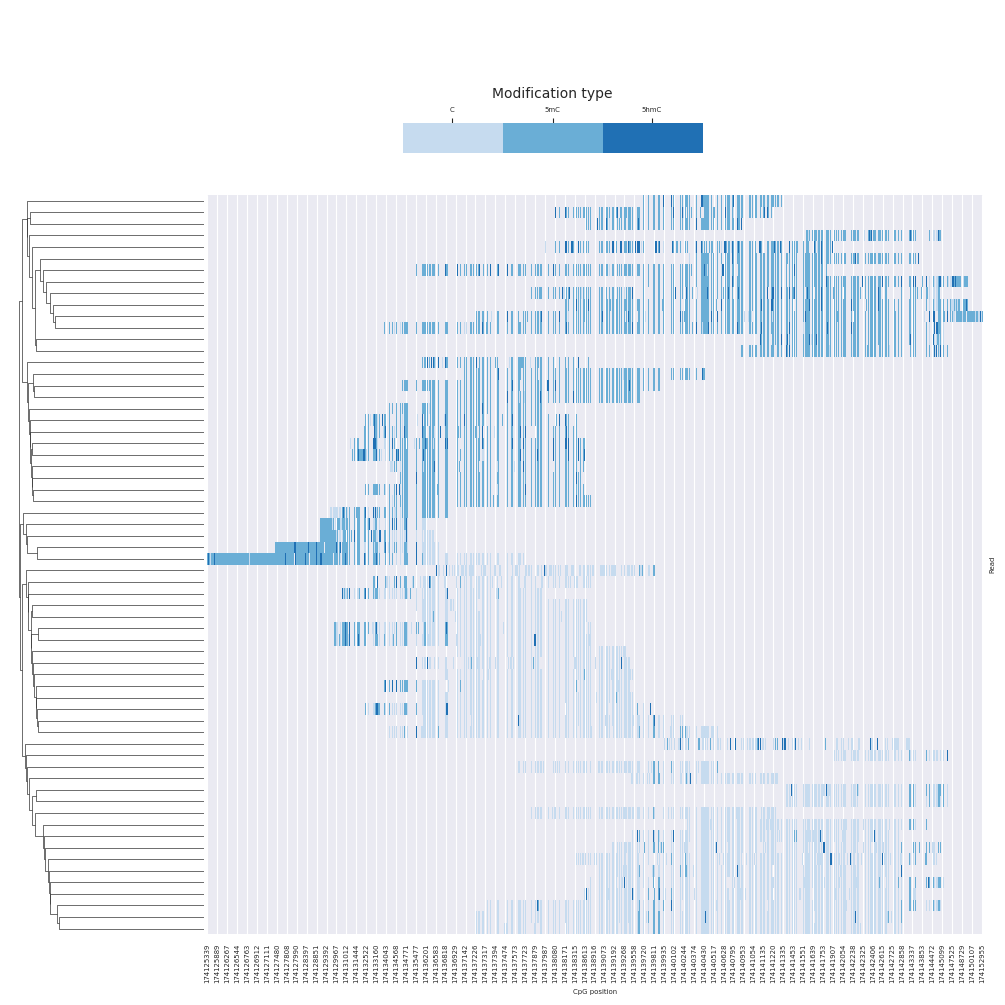

In [31]:
import seaborn as sns
import ImprintPhasing
import ModBamTools 
import pandas as pd

sns.set_style("darkgrid")

read_path = "/mnt/data1/doh28/data/prom_R10.4.1_E8.2_WGS_brain_DH/dorado_0.3.2_basecalls/alignments/prom_R10.4.1_E8.2_WGS_0.3.2_dmrs.bam"
dmr_path = "./feature_references/dmr/mm39_dmr_coordinatesEdited.bed"

dmr_regions = pd.read_csv(dmr_path, names=["Chromosome", "Start", "End", "Name", "PofO"], sep="\t").to_dict("index")
all_dmr_df = ModBamTools.CpGsFromModbam("/mnt/data1/doh28/data/prom_R10.4.1_E8.2_WGS_brain_DH/dorado_0.3.2_basecalls/alignments/prom_R10.4.1_E8.2_WGS_0.3.2_dmrs.bam", dmr_regions)

all_dmr_df.read_matrix("Nespas-Gnasxl", 0, 0.05).demo_clustermap()
# all_dmr_df.read_matrix("Nespas-Gnasxl", 0, 0.05).demo_phased_reads_as_df()["Cluster"].value_counts()

# Gnas1A_clusters = all_dmr_df.read_matrix(40, 30, "Gnas1A").demo_phased_reads_as_df() 

In [4]:
list_of_icr_regions = list(all_dmr_df.df["Name"].unique())

In [5]:
list_of_dfs = []
for icr in list_of_icr_regions:
    try:
        print(f"Analysing {icr}")
        icr_df = all_dmr_df.read_matrix(icr).as_modDF()
    except:
        print(f"Overly strict read/CpG threshold in {icr}")
        try:
            icr_df = all_dmr_df.read_matrix(icr, 0, 0.05).as_modDF()
        except: 
            print(f"Skipping {icr}")
            pass
    try: 
        list_of_dfs.append(icr_df)
    except:
        pass

Analysing Nespas-Gnasxl
Overly strict read/CpG threshold in Nespas-Gnasxl
Analysing Gnas1A
Analysing Peg10
Analysing Mest
Analysing Peg3
Analysing Snrpn
Analysing H19
Analysing Kcnq1ot1
Analysing Rasgrf1
Analysing Zac1
Analysing Grb10
Analysing U2af1-rs1
Analysing Dlk1-Gtl2
Analysing Igf2r
Analysing Impact


In [7]:
df_imprinted_genes = pd.concat(list_of_dfs)

/tmp/ipykernel_3970384/1876468471.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


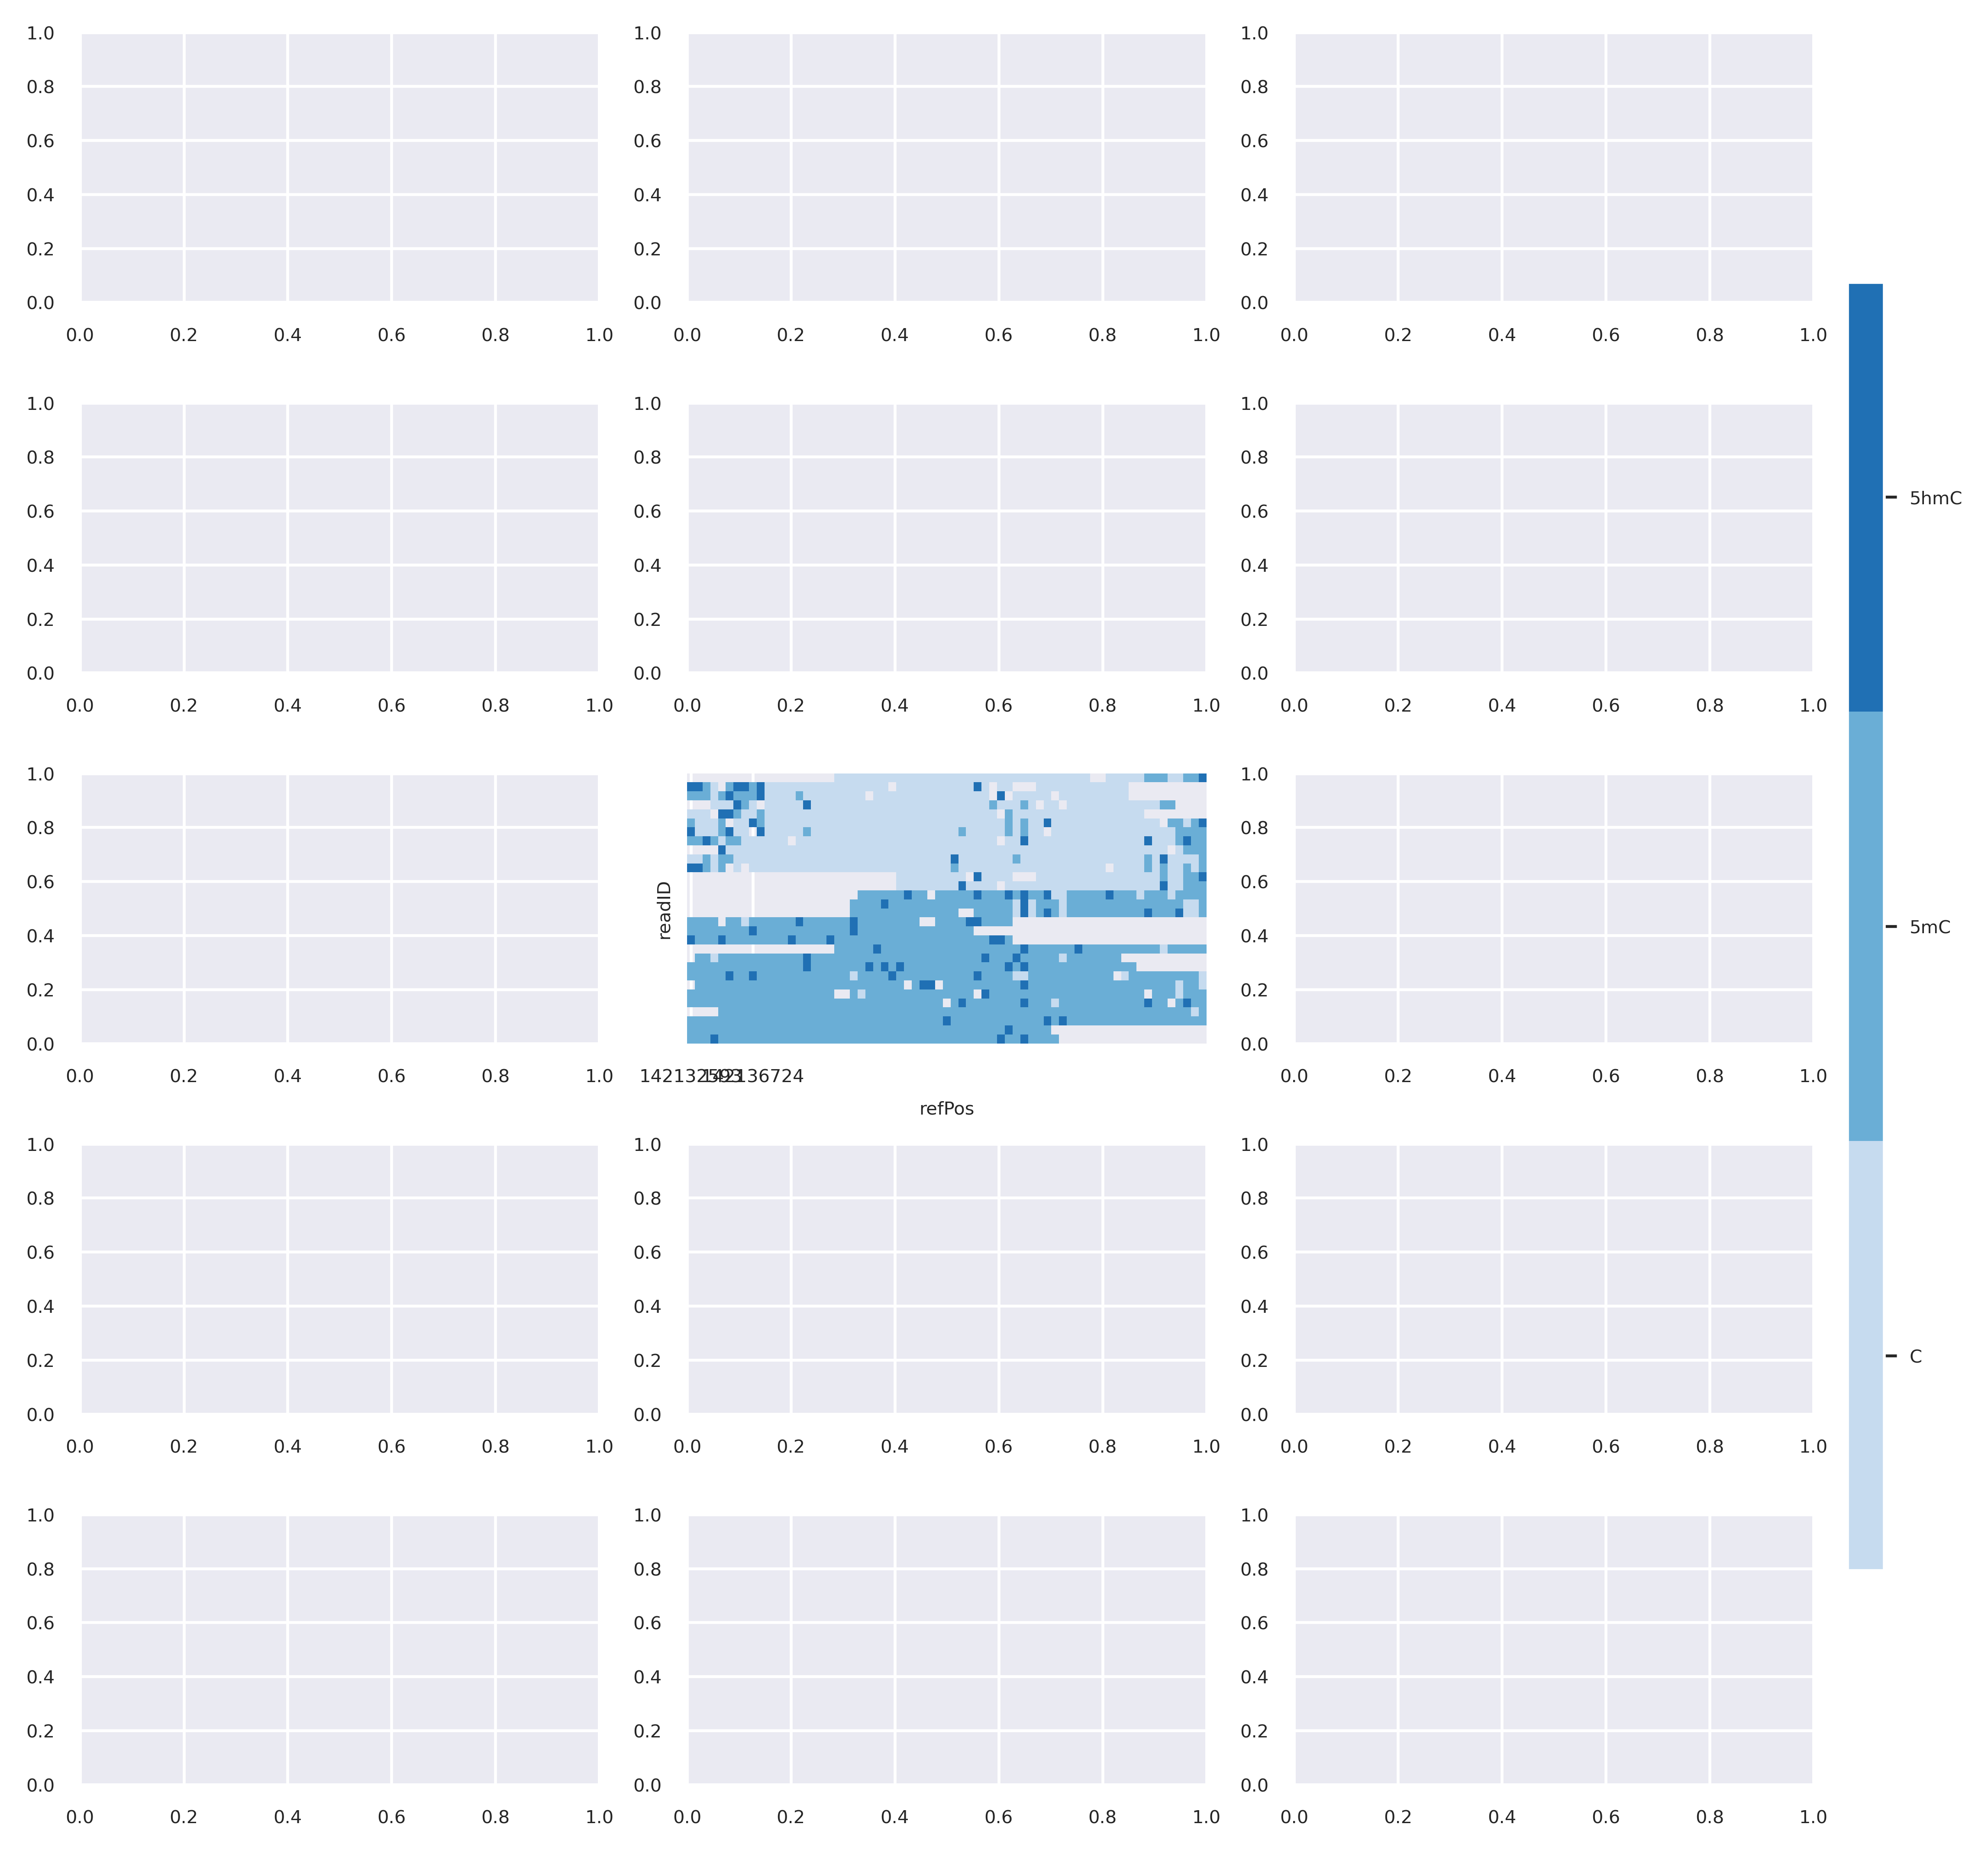

In [27]:
import matplotlib.pyplot as plt
import string
import matplotlib as mpl
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(5, 3, figsize=(180/25.4, 180/25.4), dpi=600)
axes = axes.flatten()

cmap = (mpl.colors.ListedColormap(sns.color_palette("Blues", 3)))
norm = mpl.colors.BoundaryNorm([0, 1, 2, 3], cmap.N)

cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.minorticks_off()
cbar.set_ticks([.5, 1.5, 2.5], labels=["C", "5mC", "5hmC"])

d2d = all_dmr_df.read_matrix("H19").demo_clustermap().data2d
mask = d2d == -1
hm = sns.heatmap(d2d, mask=mask,
                xticklabels="auto", yticklabels=False,
                cmap=sns.color_palette("Blues", 3),
                cbar=False,
                ax=axes[7])
hm.set_xticks([.5, 8.5], labels=[d2d.columns[0], d2d.columns[-1]], rotation="horizontal")

plt.close()
fig.tight_layout()
fig.savefig("./test_icrs.png", dpi=600, bbox_inches="tight")


## All cluster map SFig. 

/tmp/ipykernel_3970384/2729030589.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


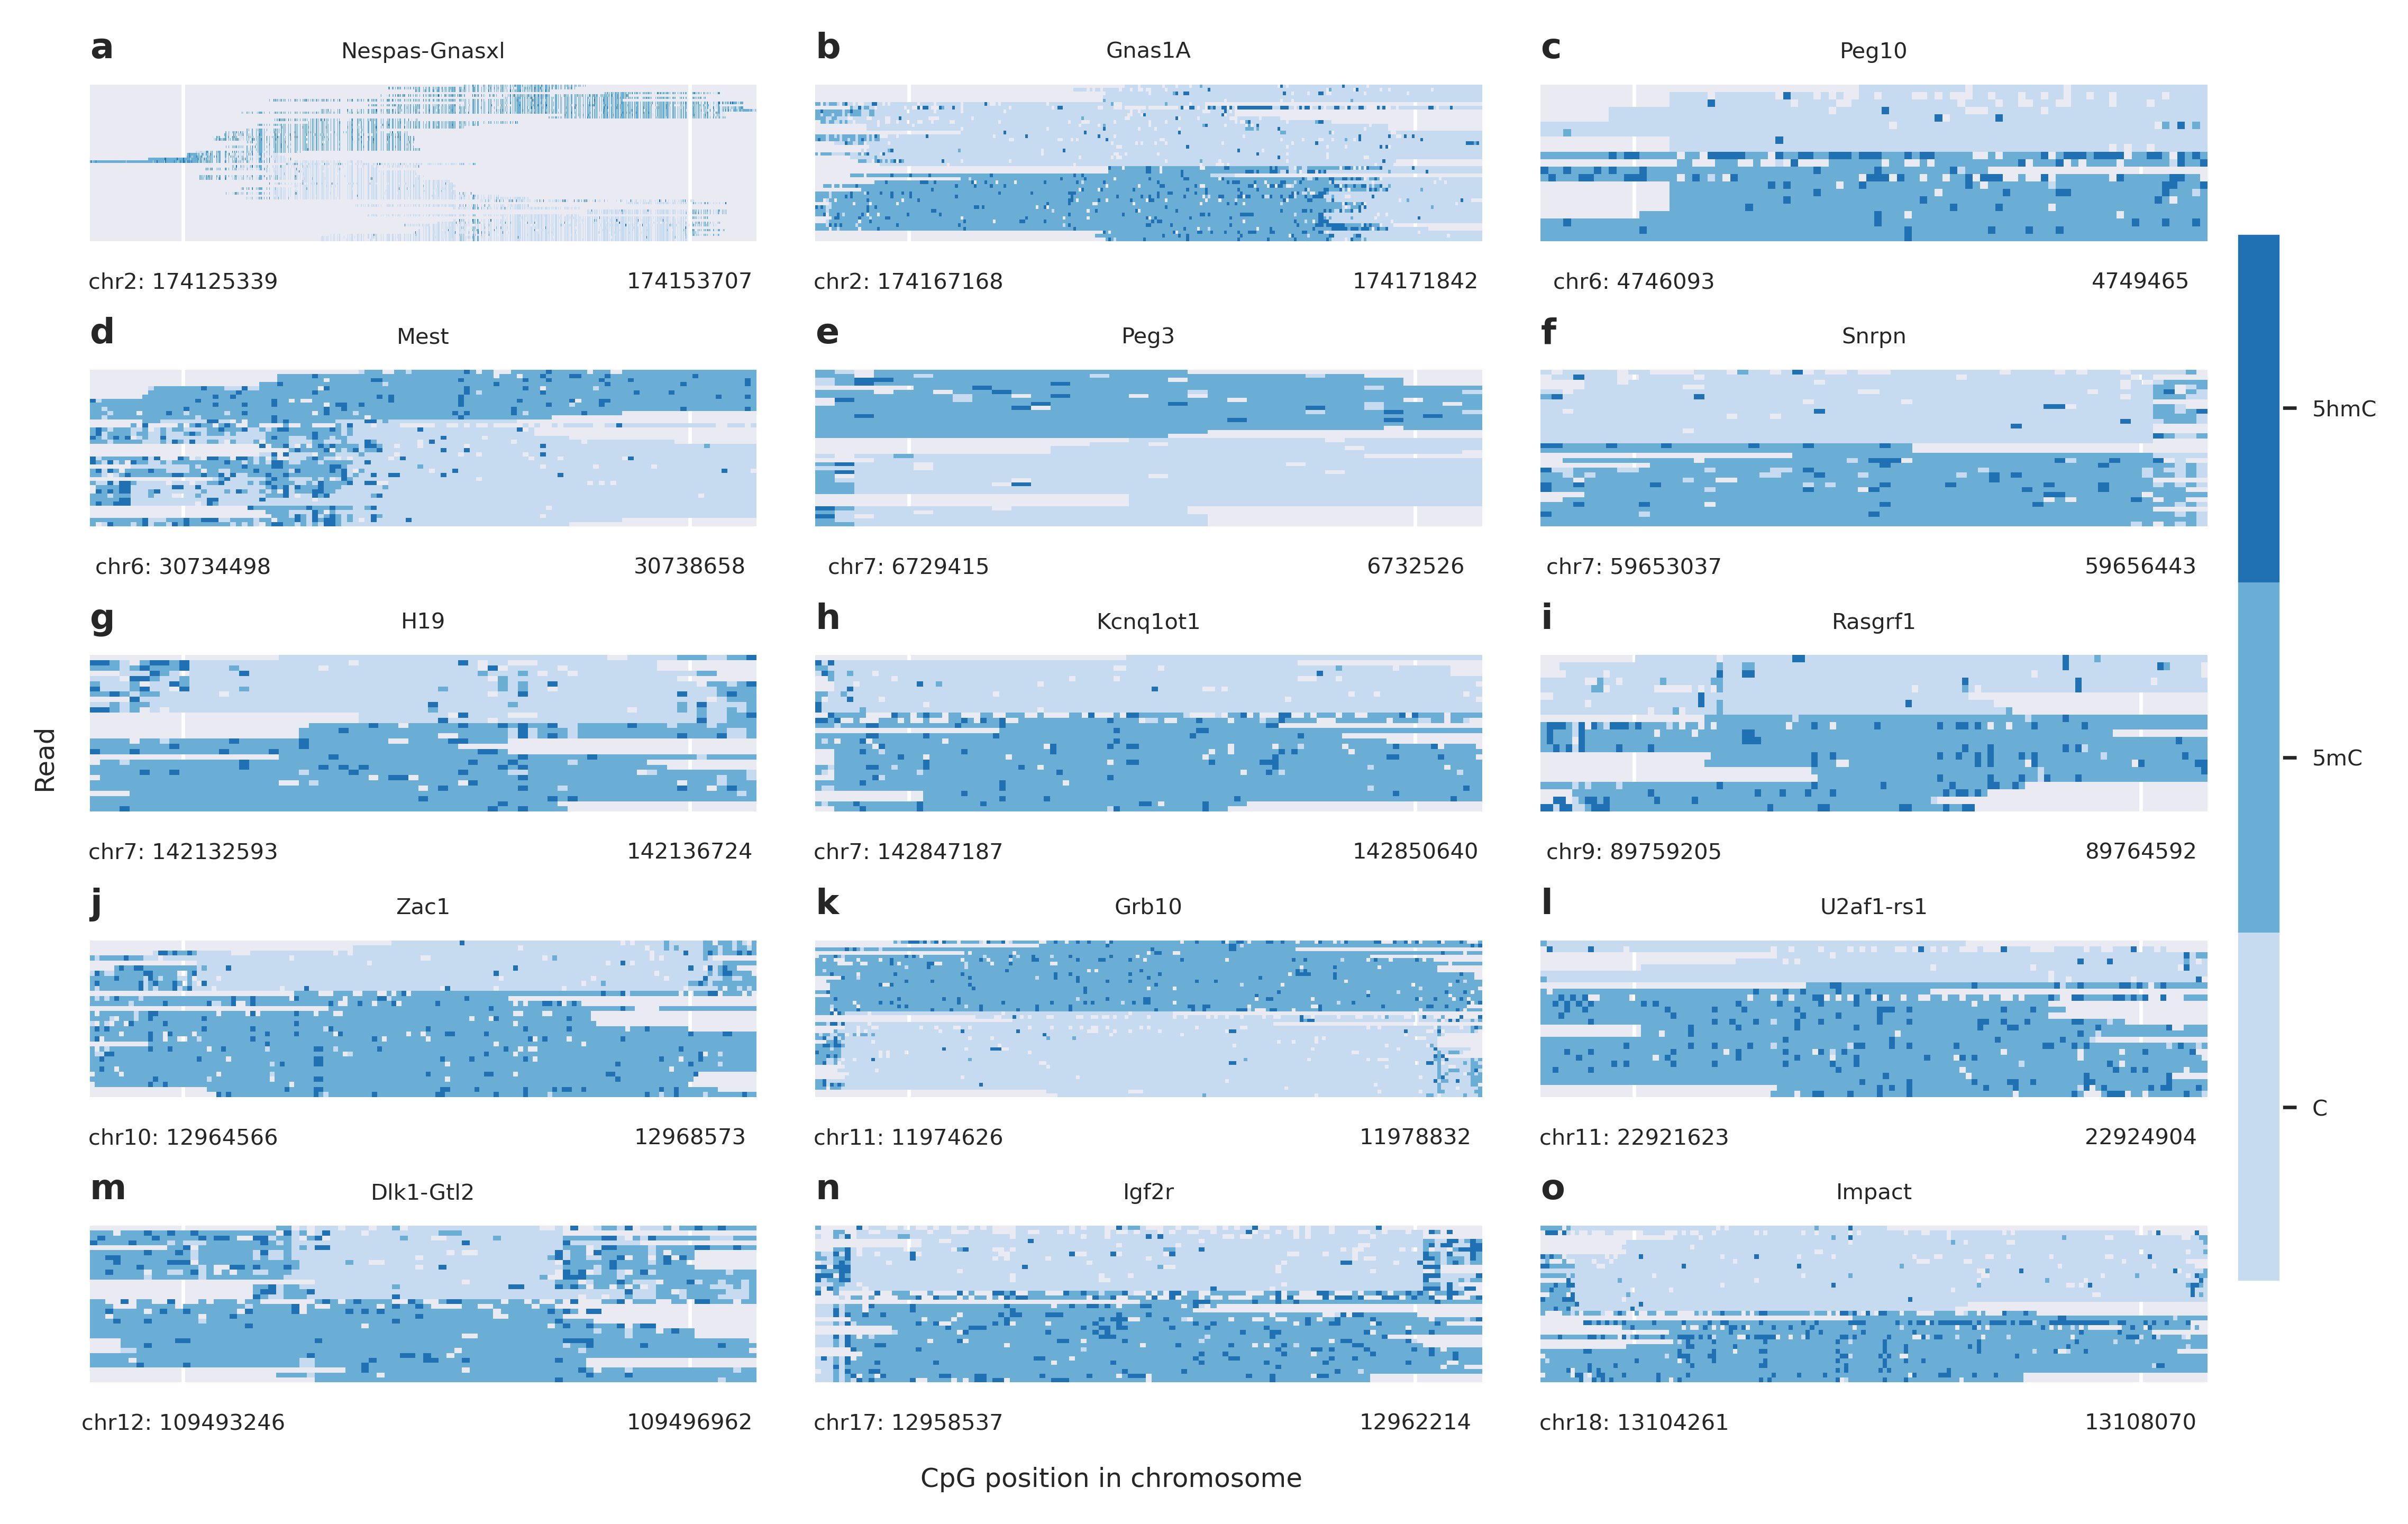

In [30]:
import matplotlib.pyplot as plt
import string
import matplotlib as mpl
import seaborn as sns

mpl.rc('font', size=5)
sns.set_style("darkgrid")

norm = mpl.colors.Normalize(vmin=0, vmax=2)

fig, axes = plt.subplots(5, 3, dpi=600, figsize=(180/25.4, 120/25.4))
axes = axes.flatten()

cmap = (mpl.colors.ListedColormap(sns.color_palette("Blues", 3)))
norm = mpl.colors.BoundaryNorm([0, 1, 2, 3], cmap.N)

cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.minorticks_off()
cbar.set_ticks([.5, 1.5, 2.5], labels=["C", "5mC", "5hmC"])

for idx, region in enumerate(list_of_icr_regions):
    ax = axes[idx]
    chromosome = all_dmr_df.df.query(f"Name == '{region}'")["Chromosome"].values[0]

    try: 
        d2d = all_dmr_df.read_matrix(region).demo_clustermap().data2d
    except:
        d2d = all_dmr_df.read_matrix(region, 0, 0.05).demo_clustermap().data2d
    mask = d2d == -1
    hm = sns.heatmap(d2d, mask=mask,
                xticklabels=False, yticklabels=False,
                cmap=sns.color_palette("Blues", 3),
                cbar=False,
                ax=ax)
    
    right = ax.get_xlim()[1]*0.9
    left = ax.get_xlim()[0] + 0.14*ax.get_xlim()[1]

    ax.set_xticks([left, right], 
                  labels=[chromosome + ": " + str(d2d.columns[0]), str(d2d.columns[-1])], rotation="horizontal")
    
    ax.set_title(f"{string.ascii_lowercase[idx]}", loc="left", fontsize=8, fontweight="bold")
    ax.set_title(f"{region}", loc="center", fontsize=5)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    plt.close()

fig.supylabel("Read")
fig.supxlabel("CpG position in chromosome")

fig.tight_layout()
fig.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/all_DMR_clusters.png", 
            dpi=600, bbox_inches="tight")

We now have the readIDs/fragments present within each allele. Within Nespas-Gnasxl there are 39 reads with approx. 98 CpG sites. Note that this can be made larger but less effective at clustering with a lower threshold on CpGs or reads. 

In [29]:
bar_df = df_imprinted_genes.replace(["c", "m", "h"], ["C", "5mC", "5hmC"])

In [ ]:
from common import pieData
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rc('font', size=5)

fig, axes = plt.subplots(1, 2, dpi=600, figsize=(120/25.4, 89/25.4))

unmethylated = bar_df.query("Cluster == 'Unmethylated'").sort_values("classification")
methylated = bar_df.query("Cluster == 'Methylated'").sort_values("classification")

mv, ml = pieData(methylated)
uv, ul = pieData(unmethylated)

axes[0].pie(uv, labels=ul, explode=(0, 0, 0.2), autopct="%1.1f%%", radius=1, colors=sns.color_palette("Paired", 3), startangle=150)
axes[0].set_title("a", loc="left", fontsize=8, fontweight="bold")
axes[0].set_title("Unmethylated clusters", loc="center", y=-.1)

axes[1].pie(mv, labels=ml, explode=(0, 0.2, 0), autopct="%1.1f%%", radius=1, colors=sns.color_palette("Paired", 3), startangle=150)
axes[1].set_title("b", loc="left", fontsize=8, fontweight="bold")
axes[1].set_title("Methylated clusters", loc="center", y=-.1)

fig.tight_layout()
fig.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/ICR_read_C_calls.png")

## Figure

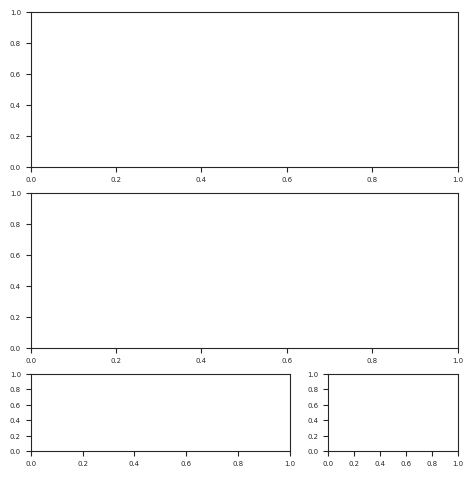

In [382]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(120/25.4, 120/25.4))
gs = GridSpec(3, 2, fig, width_ratios=(4, 2), height_ratios=(2, 2, 1))

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[2, 1])

plt.tight_layout()



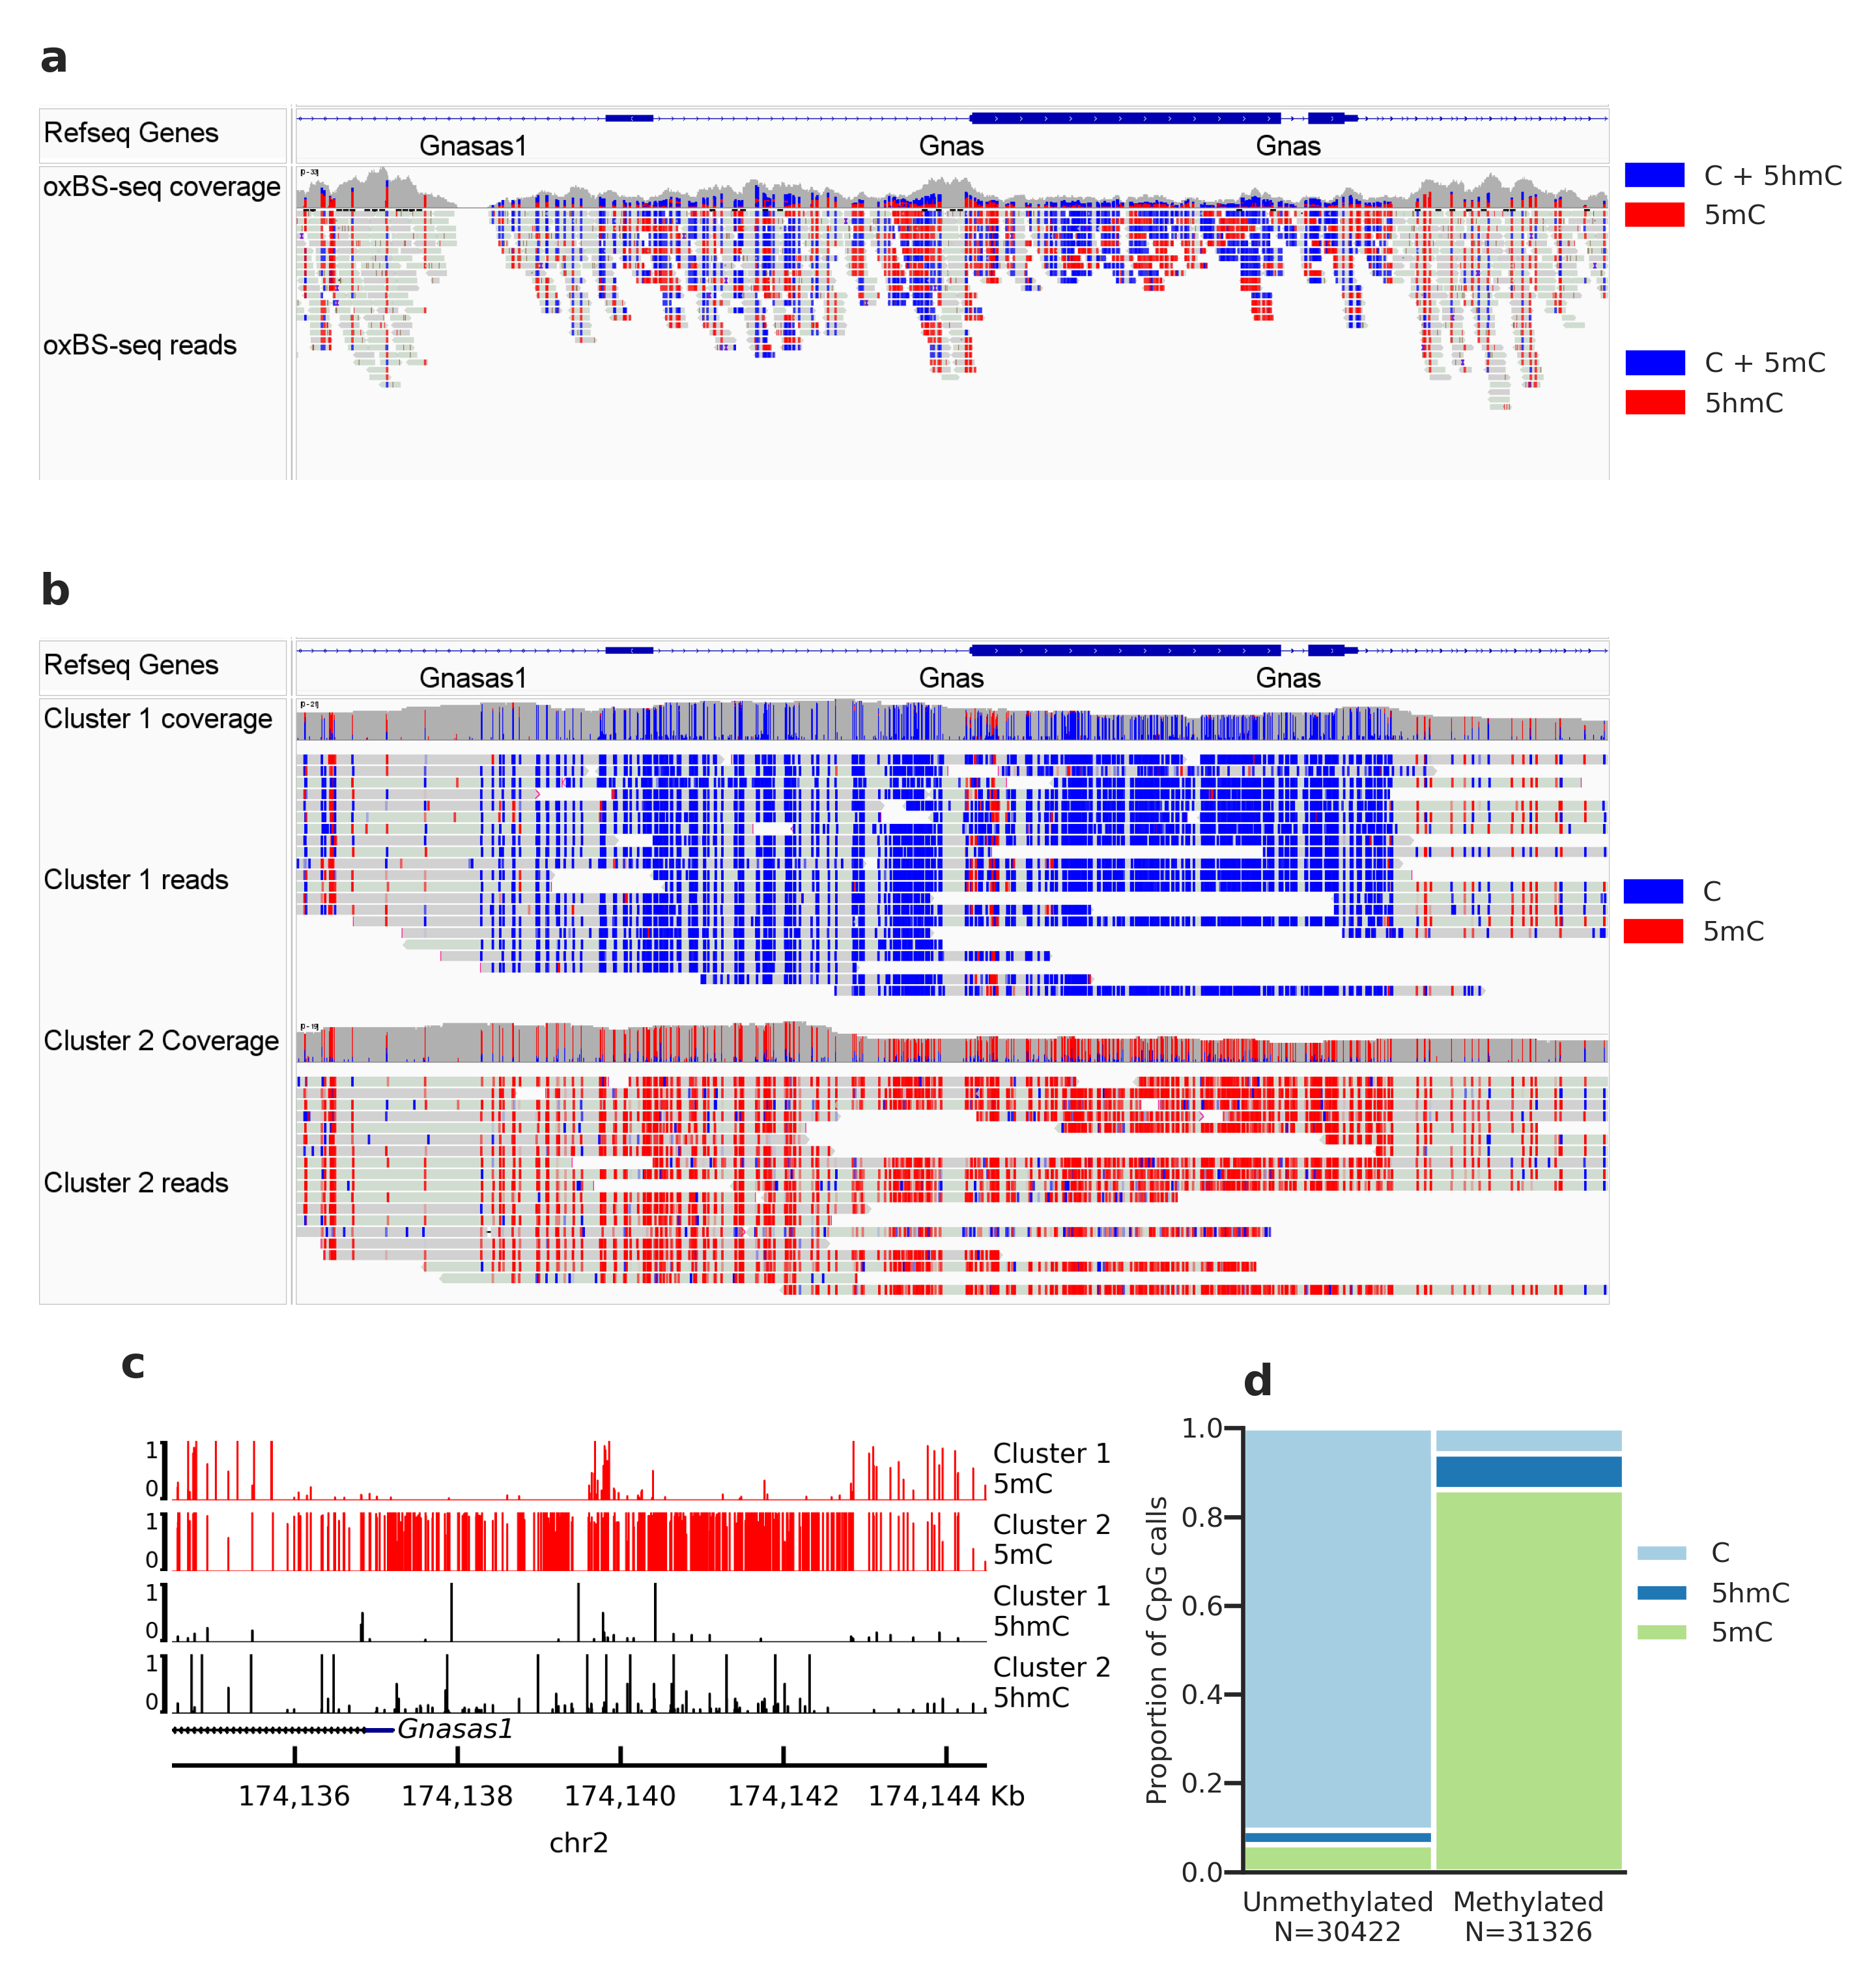

In [90]:
import seaborn as sns
import matplotlib as mpl 
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from PIL import Image
import numpy as np

sns.set_style("ticks")
mpl.rc('font', size=5)


fig = plt.figure(figsize=(120/25.4, 130/25.4), dpi=600)
gs = GridSpec(3, 3, fig, width_ratios=(3, 3, 2), height_ratios=(1, 2, 1))

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])
ax3 = fig.add_subplot(gs[2, :2])
ax4 = fig.add_subplot(gs[2, 2])

# Panel 1 # 
im1 = Image.open("./data_tables/DMR_analysis/Nespas-Gnasx_benchmarks_IGV.png")

w1, h1 = im1.size
im1c = im1.crop((0, 125, w1, 580))

ax1.imshow(im1c)
ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")

l1_elements = [Patch(facecolor='blue', edgecolor='b',
                         label='C + 5hmC'),
                   Patch(facecolor='red', edgecolor='r',
                         label='5mC')]   

l1 = ax1.legend(handles=l1_elements, loc="lower center", bbox_to_anchor=(1.07, .6), alignment="left", frameon=False)

l2_elements = [Patch(facecolor='blue', edgecolor='b',
                         label='C + 5mC'),
                   Patch(facecolor='red', edgecolor='r',
                         label='5hmC')]                       

ax1.add_artist(l1)
ax1.legend(handles=l2_elements, loc="lower center", bbox_to_anchor=(1.065, .1), alignment="left", frameon=False)

# Panel 2 # 
im2 = Image.open("./data_tables/DMR_analysis/Nespas-Gnasx_IGV.png")

w2, h2 = im2.size
im2c = im2.crop((0, 125, w2, h2))

ax2.imshow(im2c)
ax2.set_title("b", loc="left", fontsize=8, fontweight="bold")

l3_elements = [Patch(facecolor='blue', edgecolor='b',
                         label='C'),
               Patch(facecolor='red', edgecolor='r',
                         label='5mC')]   
ax2.legend(handles=l3_elements, loc="lower center", bbox_to_anchor=(1.045, .5), alignment="left", frameon=False)

# Panel 3 # 
im3 = Image.open("./data_tables/DMR_analysis/output_images/ICR_pyGenomeTracks_Img.png")
ax3.imshow(im3)
ax3.set_title("c", loc="left", fontsize=8, fontweight="bold", y=1.04)

for ax in [ax1, ax2, ax3]:
    plt.grid(False)
    sns.despine(left=True, bottom=True)
    ax.tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    ax.grid(False)

# Panel 4 # 

sns.histplot(bar_df, x="Cluster", 
             hue="classification", multiple="fill", discrete=True, stat="percent", 
             alpha=1, palette=sns.color_palette("Paired", 3),
             common_norm=True,
             hue_order=["C", "5hmC", "5mC"], 
             ax=ax4)

ax4.set_title("d", loc="left", fontsize=8, fontweight="bold", y=1)
ax4.set_xticks(["Unmethylated", "Methylated"], [f"Unmethylated\nN={len(bar_df.loc[bar_df.loc[:, 'Cluster'] == 'Unmethylated'])}", 
                                                f"Methylated\nN={len(bar_df.loc[bar_df.loc[:, 'Cluster'] == 'Methylated'])}"])
ax4.set_xlabel(None, labelpad=1)
ax4.set_ylabel("Proportion of CpG calls", labelpad=1.5)
ax4.get_legend().set_title(None)
ax4.tick_params("x", pad=0, labelbottom=True, bottom=False)
ax4.tick_params("y", which="major", pad=0)
sns.move_legend(ax4, "lower right", bbox_to_anchor=(1.5, .45), frameon=False)
sns.despine(ax=ax4, left=False)

fig.tight_layout(h_pad=-1)
fig.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/ICR_IP.png", dpi=600)

In [80]:
bbox = ax4.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
width, height = bbox.width, bbox.height
(width*25.4), (height*25.4)

(28.083677911196776, 28.84104719158498)

# hMeDIP analysis

In [1]:
import pandas as pd
import pyranges as pr
from common import *
from MultisiteTools import * 
import warnings

ip_r0_pr = pr.read_bed("./data_tables/hmedip/peak_analysis/cbm1_ip_rep0_peaks.bg")
ip_r1_pr = pr.read_bed("./data_tables/hmedip/peak_analysis/cbm1_ip_rep1_peaks.bg")
ip_r2_pr = pr.read_bed("./data_tables/hmedip/peak_analysis/cbm1_ip_rep2_peaks.bg")


### Peak depth histogram

In [2]:
ip_r_all = ip_r0_pr.join(ip_r1_pr, strandedness=None, suffix="_rep_1").join(ip_r2_pr, strandedness=None, suffix="_rep_2")
ip_r_all = ip_r_all.assign("total_peakDepth", lambda pr: pr["Name"] + pr["Name_rep_1"] + pr["Name_rep_2"])


### Feature pie chart 
Moved to SFig but calculation still necessary

In [3]:
import numpy as np
import FeatureReferences
from common import pieData

annotated_peaks = FeatureReferences.featureRefPyRange("./feature_references/genic/").join(ip_r_all, how="right", 
                                                                        strandedness=False, apply_strand_suffix=False, 
                                                                        report_overlap=True, suffix="_Peak").as_df()
annotated_peaks_grouped = annotated_peaks.sort_values("Overlap", ascending=False).groupby(
    ["Chromosome", "Start_Peak", "End_Peak", "total_peakDepth"]).head(1).replace(
    {"-1" : "Intergenic",
     "3UTR" : "Exon",
     "5UTR" : "Exon"})

# Used in SFig.
pie_values, pie_labels = pieData(annotated_peaks_grouped, 10, 15)

### Bar plot

In [4]:
import FeatureReferences

@asPyRangesDecorator
def chromSizePr():
    return loadChromSize()

tiled_genome = pr.genomicfeatures.tile_genome(chromSizePr(), 500)
annotated_genome = FeatureReferences.featureRefPyRange("./feature_references/genic/").join(tiled_genome, None, "right", apply_strand_suffix=False, 
                                                                        report_overlap=True, suffix="_Window").as_df()

annotated_genome = annotated_genome.replace([-1, "-1", "3UTR", "5UTR", "TSS"], ["Intergenic", "Intergenic", "Exon", "Exon", "Promoter"])

genome_values, genome_labels = pieData(annotated_genome)

genome = pd.DataFrame(genome_values, genome_labels, columns=["count"]).assign(proportion = lambda r: r.div(r.sum()))
peaks = pd.DataFrame(pie_values, pie_labels, columns=["count"]).assign(proportion = lambda r: r.div(r.sum()))
comp = pd.Series(np.log2(peaks["proportion"]/genome["proportion"]))

Changing colnames to be PyRanges compatible...
Done


### Bar plot 5hmC call enrichment

In [6]:
from common import *
import pyranges as pr

peaks_pr = pr.PyRanges(ip_r_all.as_df().query("total_peakDepth >= 10 & total_peakDepth <= 30"))

pilot = readModbam2bed("../../data/cbm1_ip/cbm1_ip_13_07_23/cbm1_ip_13_07_23_modified_bases_mapq60.bed", 1, False, True)
rep1 = readModbam2bed("../../data/cbm1_ip/rep1_23_16_08/modified_bases/cbm1_ip_rep1_modbases.bed", 1, False, True)
rep2 = readModbam2bed("../../data/cbm1_ip/rep2_23_05_09/basecalls/modbam2bed_out/cbm1_ip_rep2_23_05_09_q60_modbases.bed", 1, False, True)

all_reps = pd.concat([pilot, rep1, rep2], ignore_index=True)
grouped_cpgs = all_reps.groupby(["chromosome", "chromStart", "chromEnd", "strand"]).agg({
    "readCount" : sum,
    "N_C" : sum,
    "N_mC" : sum,
    "N_hmC" : sum
}).reset_index()

top_peak_cpgs = peaks_pr.join(asPyRanges(grouped_cpgs), suffix="_CpG").as_df()
top_peak_cpgs = top_peak_cpgs.drop(columns=["Name", "Start_rep_1", "End_rep_1" ,"Name_rep_1", "Start_rep_2", "End_rep_2", "Name_rep_2"])

Changing colnames to be PyRanges compatible...
Done


In [10]:
if not "prom_raw" in locals().keys():
    prom_raw = readModbam2bed("/mnt/data1/doh28/data/prom_R10.4.1_E8.2_WGS_brain_DH/dorado_0.3.2_basecalls/modbases/cbm1_prom_modbases_mapq60.bed", 1, False, True)

wgs_cpgs_agg = prom_raw.agg({
    "N_C" : sum, 
    "N_mC" : sum, 
    "N_hmC" : sum
})
c_call_enrichment_wgs = pd.DataFrame(wgs_cpgs_agg, columns=["count"]).assign(proportion = lambda r: r.div(r.sum()))

agg_peak_cpgs = top_peak_cpgs.agg({
    "N_C" : sum, 
    "N_mC" : sum, 
    "N_hmC" : sum
})
c_call_enrichment_peak = pd.DataFrame(agg_peak_cpgs, columns=["count"]).assign(proportion = lambda r: r.div(r.sum()))

bar_comp = pd.Series(np.subtract((c_call_enrichment_peak["proportion"]/c_call_enrichment_wgs["proportion"]), 1)*100)
bar_comp.index = ["C", "5mC", "5hmC"]

In [11]:
bar_comp

C        67.568537
5mC     -49.939914
5hmC    213.751059
Name: proportion, dtype: float64

### Peak context histogram
Note: Different thresholds on CpG depth for TAB mean different numbers of CpGs overall.

In [20]:
import numpy as np
from common import asPyRanges

prom_comp_data = pd.read_csv("./data_tables/intermediates_comparison_files/prom_comp_data_10x.tsv")

# renaming columns for compatability with PyRanges
prom_comp_data = asPyRanges(prom_comp_data).as_df()

prom_comp_pr = CpGRange(prom_comp_data).unstrand()

Changing colnames to be PyRanges compatible...
Done


In [21]:
with warnings.catch_warnings():
    tiles = pr.PyRanges(prom_comp_pr.group_by_tile(1000).enrichment_over_mean(include_zeros=True).df)
    
tiled_peak_df = ip_r_all.join(tiles, suffix="_Tile", report_overlap=True).as_df()
tiled_peak_df = tiled_peak_df.sort_values("Overlap",ascending=False).groupby(["Chromosome", "Start", "End"]).head(1)

tiled_peak_df["peakDepth_cat"] = pd.cut(tiled_peak_df["total_peakDepth"], 
                                        bins=[10, 14, 18, np.inf],
                                        labels=[10, 14, "18+"],
                                        include_lowest=True, right=False)

histplot_df = ip_r_all.as_df().melt(["Chromosome", "Start", "End"], ["Name", "Name_rep_1", "Name_rep_2"], var_name="Replicate", value_name="peakDepth").replace(
    ["Name", "Name_rep_1", "Name_rep_2"], 
    ["Pilot", "Rep. 1", "Rep. 2"]
)

Aggregating all of ['percentMeth_5mC_Nanopore', 'percentMeth_5mC_oxBS', 'percentMeth_5hmC_Nanopore', 'percentMeth_5hmC_TAB']


Note - only using top 10% of most CpG rich tiles (X >= 6)

## Figure

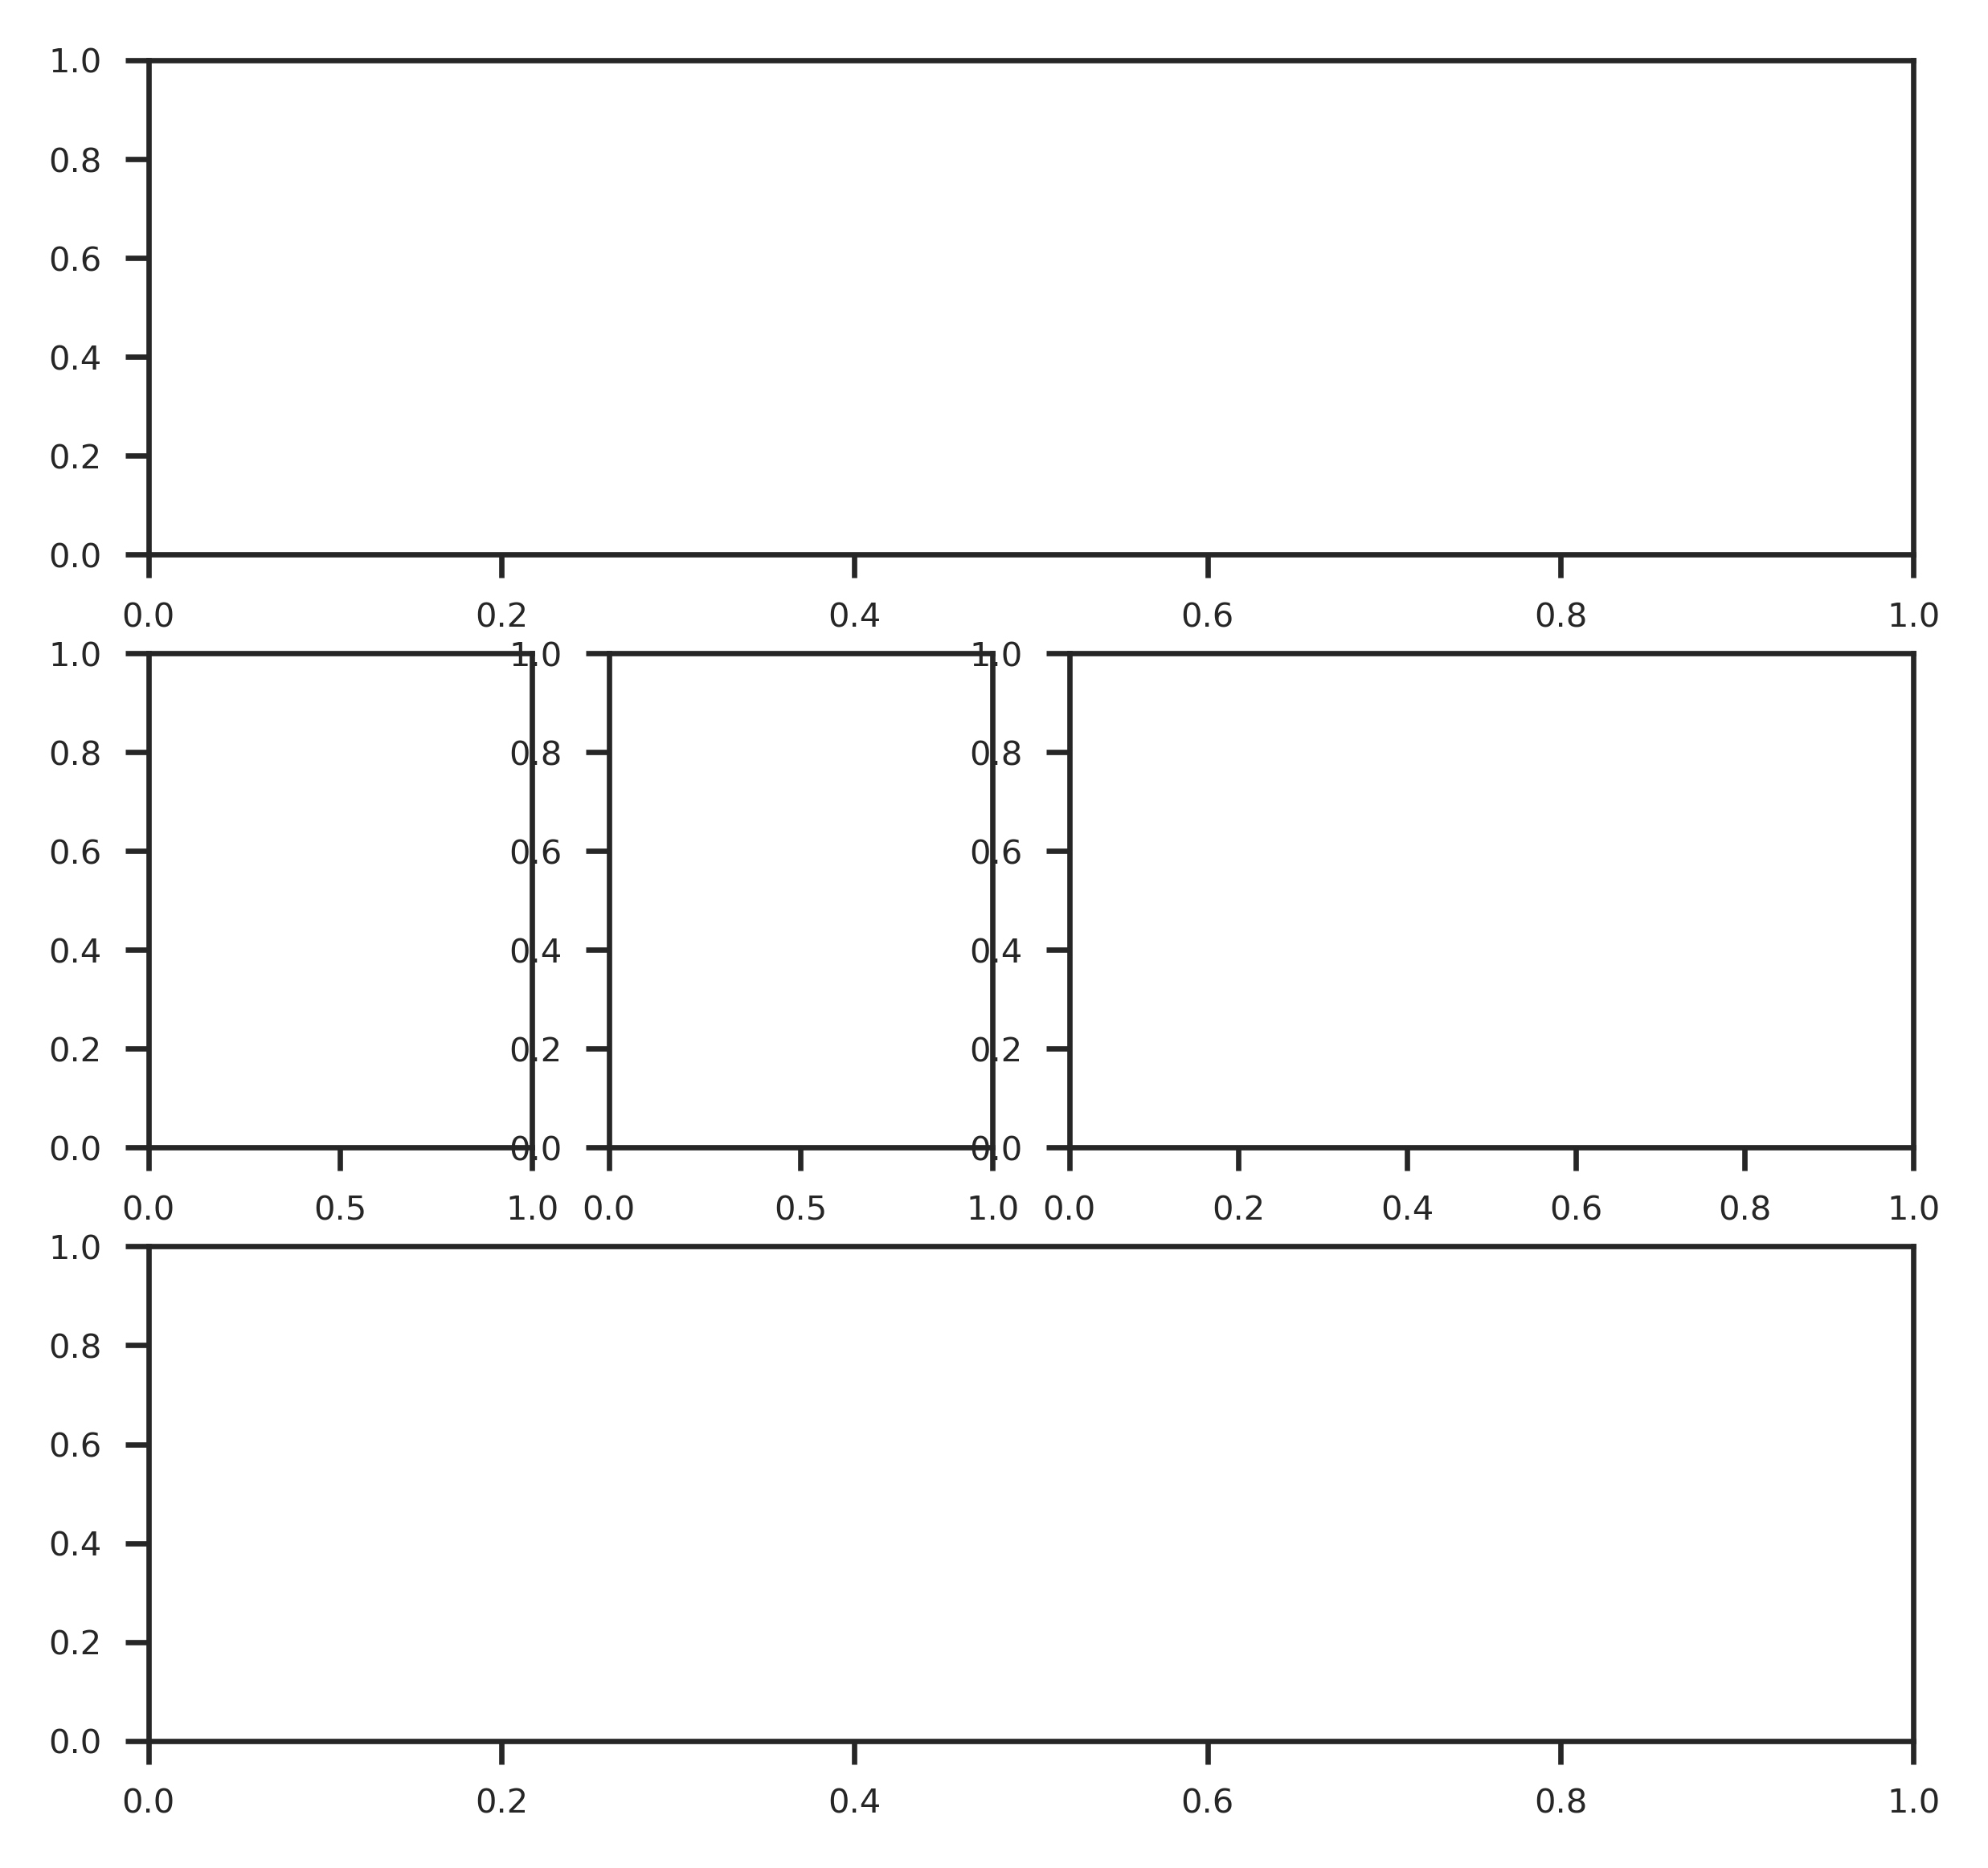

In [147]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(120/25.4, 115/25.4), dpi=600)

gs = GridSpec(3, 4, fig)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[1, 2:])
ax5 = fig.add_subplot(gs[2, :])


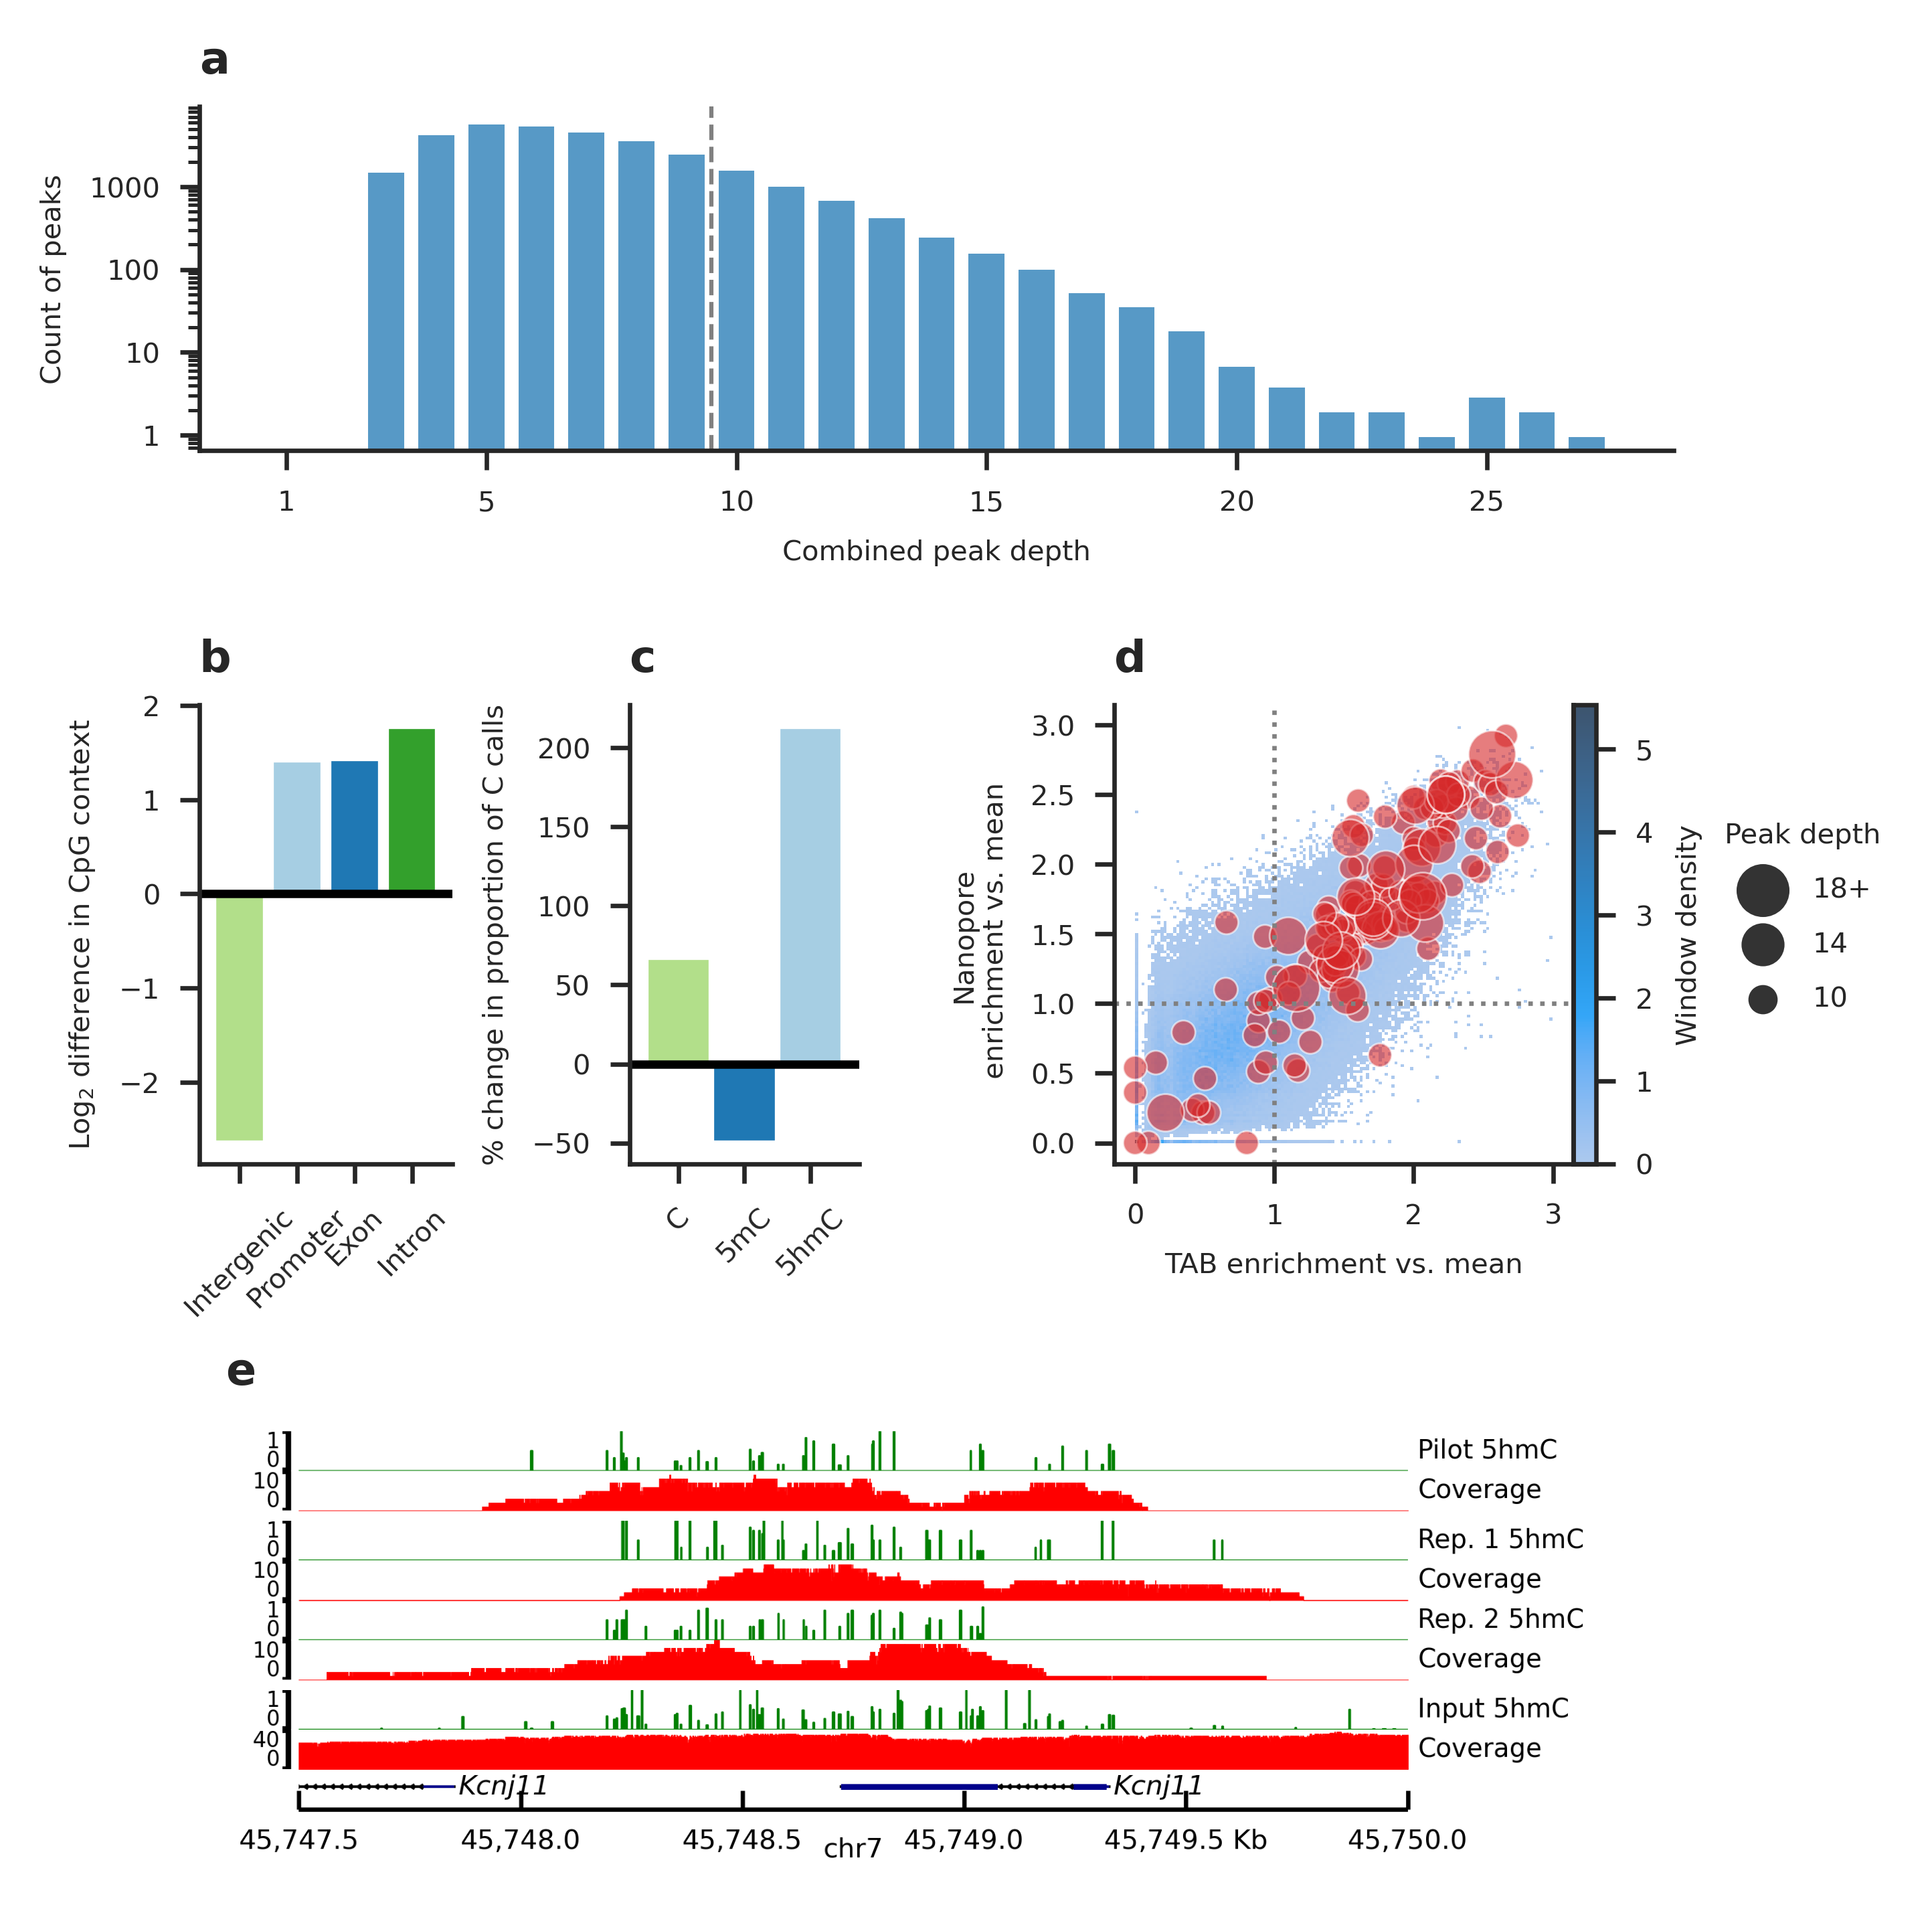

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

fig = plt.figure(figsize=(120/25.4, 120/25.4), dpi=600)
sns.set_style("ticks")
mpl.rc('font', size=5)

gs = GridSpec(3, 4, fig, height_ratios=(0.75, 1, 1), width_ratios=(1.1, 1, 1, 1))

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[1, 2:])
ax5 = fig.add_subplot(gs[2, :])

# Panel 1 # 

binmax = 27 
sns.histplot(ip_r_all.as_df(), x="total_peakDepth", 
             binrange=(1, binmax), discrete=True, shrink=0.8, log_scale=(False, True), element="bars",  
             ax=ax1)

ax1.set_xticks([1, 5, 10, 15, 20, 25])
ax1.set_xlabel("Combined peak depth")
ax1.set_ylabel("Count of peaks")
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter("%1i"))

ax1.axvline(9.5, lw=0.75, ls="--", c="grey")
ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")

# Panel 2 #

colors = [sns.color_palette("Paired", 4)[2], sns.color_palette("Paired", 4)[0], sns.color_palette("Paired", 4)[1], sns.color_palette("Paired", 4)[3]]
comp.sort_values().plot.bar(ax=ax2, 
                            width=.9,
                            color=colors)
ax2.set_title("b", loc="left", fontsize=8, fontweight="bold")
ax2.axhline(0, c="k")
ax2.set_ylabel(f"Log$_{2}$ difference in CpG context")
ax2.tick_params(axis="x", which="both", labelrotation=45)

# Panel 3 #

ax3.axhline(0, c="k")
ax3.set_title("c", loc="left", fontsize=8, fontweight="bold")
bar_comp.plot.bar(color=sns.color_palette("Paired", 3)[::-1], 
                  width=1,
                  ax=ax3)
ax3.set_ylabel(f"% change in proportion of C calls")
ax3.tick_params(axis="x", which="both", labelrotation=45)


# Panel 5 # 

div4 = make_axes_locatable(ax4)
cax4 = div4.append_axes("right", size="5%", pad=0)

sns.histplot(tiles.as_df().query("CpG_count >= 6"), x="log2enrichment_5hmC_TAB", y="log2enrichment_5hmC_Nanopore", 
             stat="density", 
             cbar=True, cbar_kws={"label" : "Window density"}, cbar_ax=cax4, ax=ax4)
sns.scatterplot(tiled_peak_df.query("CpG_count >= 6 & total_peakDepth >= 10 & total_peakDepth <= 30").sort_values("total_peakDepth"), 
                x="log2enrichment_5hmC_Nanopore", y="log2enrichment_5hmC_TAB", 
                size="peakDepth_cat", size_order=["18+", 14, 10], s=.5,
                alpha=.6, c="tab:red", ax=ax4)

ax4.axvline(x=1, ls=":", c="grey", lw=0.8)
ax4.axhline(y=1, ls=":", c="grey", lw=0.8)
ax4.set_aspect("equal")
ax4.set_xlabel("TAB enrichment vs. mean")
ax4.set_ylabel("Nanopore\n enrichment vs. mean")
ax4.legend(title="Peak depth", loc="upper center", frameon=False, bbox_to_anchor=(1.5, .8), labelspacing=1)

ax4.set_title("d", loc="left", fontsize=8, fontweight="bold")

# Panel 6 # 

im5 = plt.imread("./data_tables/hmedip/rep_image/output_img/hmedip_repImg1.png")
ax5.imshow(im5)
ax5.grid(False)
ax5.tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
ax5.set_title("e", loc="left", fontsize=8, fontweight="bold")

sns.despine(fig)
sns.despine(ax=ax5, bottom=True, left=True, right=True)

fig.tight_layout()
fig.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/hMeDIP.png", dpi=600)

In [14]:
ax_h, ax_w = ax1.bbox.height, ax1.bbox.width
ax_h/fig.dpi*2.54, ax_w/fig.dpi*2.54

(2.260324362171623, 9.32905116005628)

How many peaks?

In [42]:
tiled_peak_df.query("total_peakDepth >= 10 & total_peakDepth <= 30").rename(columns={"Start_rep_0" : "Start", "End_rep_0" : "End"})


How CpG dense? 

In [ ]:
tiled_peak_pr = pr.PyRanges(tiled_peak_df)
all_overlaps = ip_r0_pr.overlap(ip_r1_pr).overlap(ip_r2_pr).overlap(tiled_peak_pr)
mouse_genome_overlaps = pr.get_sequence(all_overlaps, "../../data/reference_genomes/mm39/mm39.fa")

In [ ]:
densities = []
for sequence in mouse_genome_overlaps: 
    cpg_count = sequence.upper().count("CG")
    total_length = len(sequence)
    density = (cpg_count/total_length)*100 
    densities.append(density)

# calculated in GeneralNotes.ipynb
genome_cg_density = 0.48245101843420024
(sum(densities)/len(densities))/genome_cg_density

How many peaks in enriched area? 

In [ ]:
df = tiled_peak_df.query("CpG_count >= 6 & total_peakDepth >= 10 & total_peakDepth <= 30")
len(df.query("log2enrichment_5hmC_TAB > 1"))/len(df)

0.8421052631578947

What % of all CpG-context C calls are C/5mC/5hmC?

In [43]:
from common import *
import pyranges as pr

peaks_pr = pr.PyRanges(ip_r_all.as_df().query("total_peakDepth >= 10 & total_peakDepth <= 30"))

pilot = readModbam2bed("../../data/cbm1_ip/cbm1_ip_13_07_23/cbm1_ip_13_07_23_modified_bases_mapq60.bed", 1, False, True)
rep1 = readModbam2bed("../../data/cbm1_ip/rep1_23_16_08/modified_bases/cbm1_ip_rep1_modbases.bed", 1, False, True)
rep2 = readModbam2bed("../../data/cbm1_ip/rep2_23_05_09/basecalls/modbam2bed_out/cbm1_ip_rep2_23_05_09_q60_modbases.bed", 1, False, True)

In [44]:
all_reps = pd.concat([pilot, rep1, rep2], ignore_index=True)
grouped_cpgs = all_reps.groupby(["chromosome", "chromStart", "chromEnd", "strand"]).agg({
    "readCount" : sum,
    "N_C" : sum,
    "N_mC" : sum,
    "N_hmC" : sum
}).reset_index()

In [45]:
top_peak_cpgs = peaks_pr.join(asPyRanges(grouped_cpgs), suffix="_CpG").as_df()
top_peak_cpgs = top_peak_cpgs.drop(columns=["Name", "Start_rep_1", "End_rep_1" ,"Name_rep_1", "Start_rep_2", "End_rep_2", "Name_rep_2"])

Changing colnames to be PyRanges compatible...
Done


In [ ]:
n_hmc = top_peak_cpgs["N_hmC"].sum()
n_mc = top_peak_cpgs["N_mC"].sum()
all_cpgs = top_peak_cpgs["readCount"].sum()

n_hmc/all_cpgs, n_mc/all_cpgs

(0.2834937036048751, 0.3441204175521056)

28.3% of all CpG-context C calls are 5hmC in these peaks. 

In [ ]:
prom_raw = readModbam2bed("/mnt/data1/doh28/data/prom_R10.4.1_E8.2_WGS_brain_DH/dorado_0.3.2_basecalls/modbases/cbm1_prom_modbases_mapq60.bed", 1, False, True)

In [ ]:
prom_raw["N_hmC"].sum()/prom_raw["readCount"].sum(), prom_raw["N_mC"].sum()/prom_raw["readCount"].sum()

(0.09035625398674801, 0.6874147492211372)

By contrast, only 9.0% of CpG-context C calls were 5hmC in the nanopore WGS, and 10.4 in the TAB WGS.

In [ ]:
tab_raw = readBismarkZeroCov("/mnt/data1/doh28/data/CRR008807_TAB/mapq_filtered/modified_bases/CRR008807_TAB_merged_resorted_q10.bedGraph.gz.bismark.zero.cov", "5hmC", 1, False, True)

In [ ]:
tab_raw["N_mod"].sum()/tab_raw["readCount"].sum()

0.10413366815626074

## SFig 2

How does average peak 5hmC % correlate with region 5hmC in WGS? 

In [9]:
top_peaks_5hmC = top_peak_cpgs.groupby(["Chromosome", "Start", "End"], observed=True).agg({
    "N_hmC" : sum,
    "readCount" : sum
}).reset_index()
top_peaks_5hmC = top_peaks_5hmC.assign(percentMeth_5hmC = lambda r: (r["N_hmC"].div(r["readCount"])*100))

In [10]:
peaks_vs_wgs = pr.PyRanges(top_peaks_5hmC).join(tiles, suffix="_tile").as_df()

In [11]:
from scipy import stats
stats.pearsonr(peaks_vs_wgs["percentMeth_5hmC"], peaks_vs_wgs["percentMeth_5hmC_Nanopore"])

PearsonRResult(statistic=0.15652422854010833, pvalue=1.3468521389595136e-13)

In [ ]:
top_peaks_5hmC["percentMeth_5hmC"].mean()

35.425745697552834

In [ ]:
(top_peaks_5hmC["End"]-top_peaks_5hmC["Start"]).median()

603.0

In [ ]:
tiles.as_df()["percentMeth_5hmC_Nanopore"].mean()

8.609406646323405

### Venn Diagram

In [12]:
def VennDiagrammer(r0, r1, r2, ax):
    r0_only = len(r0.intersect(r1, invert=True).intersect(r2, invert=True))
    r1_only = len(r1.intersect(r2, invert=True).intersect(r0, invert=True))
    r2_only = len(r2.intersect(r0, invert=True).intersect(ip_r1_pr, invert=True))

    r01 = len(r0.intersect(r1, invert=False).intersect(r2, invert=True))
    r02 = len(r0.intersect(r2, invert=False).intersect(r1, invert=True))
    r12 = len(r1.intersect(r2, invert=False).intersect(r0, invert=True))

    r012 = len(r0.intersect(r1, invert=False).intersect(r2, invert=False))
    
    total = sum([r0_only, r1_only, r2_only, r01, r02, r12, r012])

    venn = venn3(
        {
    "001" : r0_only,
    "010" : r1_only,
    "100" : r2_only,
    "011" : r01,
    "110" : r12,
    "101" : r02,
    "111" : r012
    },
    set_labels=["Rep. 2", "Rep. 1" , "Pilot"],
    set_colors=[sns.color_palette("Paired", 3)[2], sns.color_palette("Paired", 3)[1], sns.color_palette("Paired", 3)[0]],
    alpha=1,
    subset_label_formatter=lambda x: f"{(x/total):1.1%}",
    ax=ax)
    
    return venn

In [13]:
import pyranges as pr

def prPeakDepth(pyrange, min_peakDepth):
    df = pyrange.as_df() 
    df = df.query(f"Name >= {min_peakDepth}")
    return pr.PyRanges(df)
    

### Scatter hist

In [14]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=FutureWarning)
    annotated_tiled_peaks = pr.PyRanges(tiled_peak_df).join(FeatureReferences.featureRefPyRange("./feature_references/genic/"), how="left", apply_strand_suffix=False).as_df()

In [15]:
annotated_tiled_peaks = annotated_tiled_peaks.replace(["3UTR", "5UTR", "TSS", "-1"], ["Exon", "Exon", "Promoter", "Intergenic"]).rename(columns={"feature_type" : "Primary overlap", "peakDepth_cat" : "Peak depth"})
annotated_tiled_peaks = annotated_tiled_peaks.query("CpG_count >= 6")

Possible issue in how nanopore 5hmC is aggregated here: Note that the top region has 0% 5hmC but in IGV clearly does have it.

In [16]:
annotated_tiled_peaks.sort_values("log2enrichment_5hmC_Nanopore").drop(columns=["Start_rep_2", "End_rep_2", "Name_rep_1", "Name_rep_2"])

Chromosome      Start        End  Name  Start_rep_1  End_rep_1  \
9356        chr8  120282424  120282764     2    120282183  120282836   
14289      chr13   91187665   91188051     1     91187686   91188529   
10234       chr9  122122269  122122823     2    122122424  122122723   
16311      chr16   23968503   23969026     2     23968487   23969037   
336         chr1   82702092   82702386     4     82701946   82702611   
...          ...        ...        ...   ...          ...        ...   
13416      chr12  103390269  103390889     2    103390394  103390994   
13417      chr12  103390269  103390889     2    103390394  103390994   
13418      chr12  103390269  103390889     2    103390394  103390994   
10607       chr9   49631843   49632065     1     49631751   49632576   
15073      chr14   94118680   94118974     2     94118490   94119049   

       total_peakDepth  Start_Tile   End_Tile  percentMeth_5mC_Nanopore  ...  \
9356                 4   120282000  120283000                  4.052288  ...   
14289                7    91187000   91188000                  6.944444  ...   
10234                6   122122000  122123000                  0.000000  ...   
16311               10    23968000   23969000                 10.921946  ...   
336                  9    82702000   82703000                  0.000000  ...   
...                ...         ...        ...                       ...  ...   
13416               13   103390000  103391000                 36.570097  ...   
13417               13   103390000  103391000                 36.570097  ...   
13418               13   103390000  103391000                 36.570097  ...   
10607                7    49631000   49632000                 34.860140  ...   
15073                8    94118000   94119000                 23.823954  ...   

       log2enrichment_5mC_Nanopore  log2enrichment_5mC_oxBS  \
9356                      0.075076                 0.021015   
14289                     0.126366                 0.159699   
10234                     0.000000                 0.023621   
16311                     0.194051                 0.071755   
336                       0.000000                 0.041729   
...                            ...                      ...   
13416                     0.567605                 0.562164   
13417                     0.567605                 0.562164   
13418                     0.567605                 0.562164   
10607                     0.545495                 0.712329   
15073                     0.394013                 0.612503   

       log2enrichment_5hmC_Nanopore  log2enrichment_5hmC_TAB  Overlap  \
9356                       0.000000                 0.714404      340   
14289                      0.000000                 1.018777      335   
10234                      0.000000                 0.000000      554   
16311                      0.000000                 0.361831      497   
336                        0.000000                 0.000000      294   
...                             ...                      ...      ...   
13416                      2.747619                 2.206539      620   
13417                      2.747619                 2.206539      620   
13418                      2.747619                 2.206539      620   
10607                      2.765650                 2.178985      157   
15073                      2.963727                 2.520741      294   

       Peak depth    Start_b      End_b  Strand Primary overlap  
9356          NaN  120274624  120285384       -          Intron  
14289         NaN   91170786   91188968       -          Intron  
10234         NaN  122104729  122123369       -          Intron  
16311          10         -1         -1       +      Intergenic  
336           NaN   82701589   82702649       +        Promoter  
...           ...        ...        ...     ...             ...  
13416          10  103390130  103390856       -            Exon  
13417          10 

### Figure

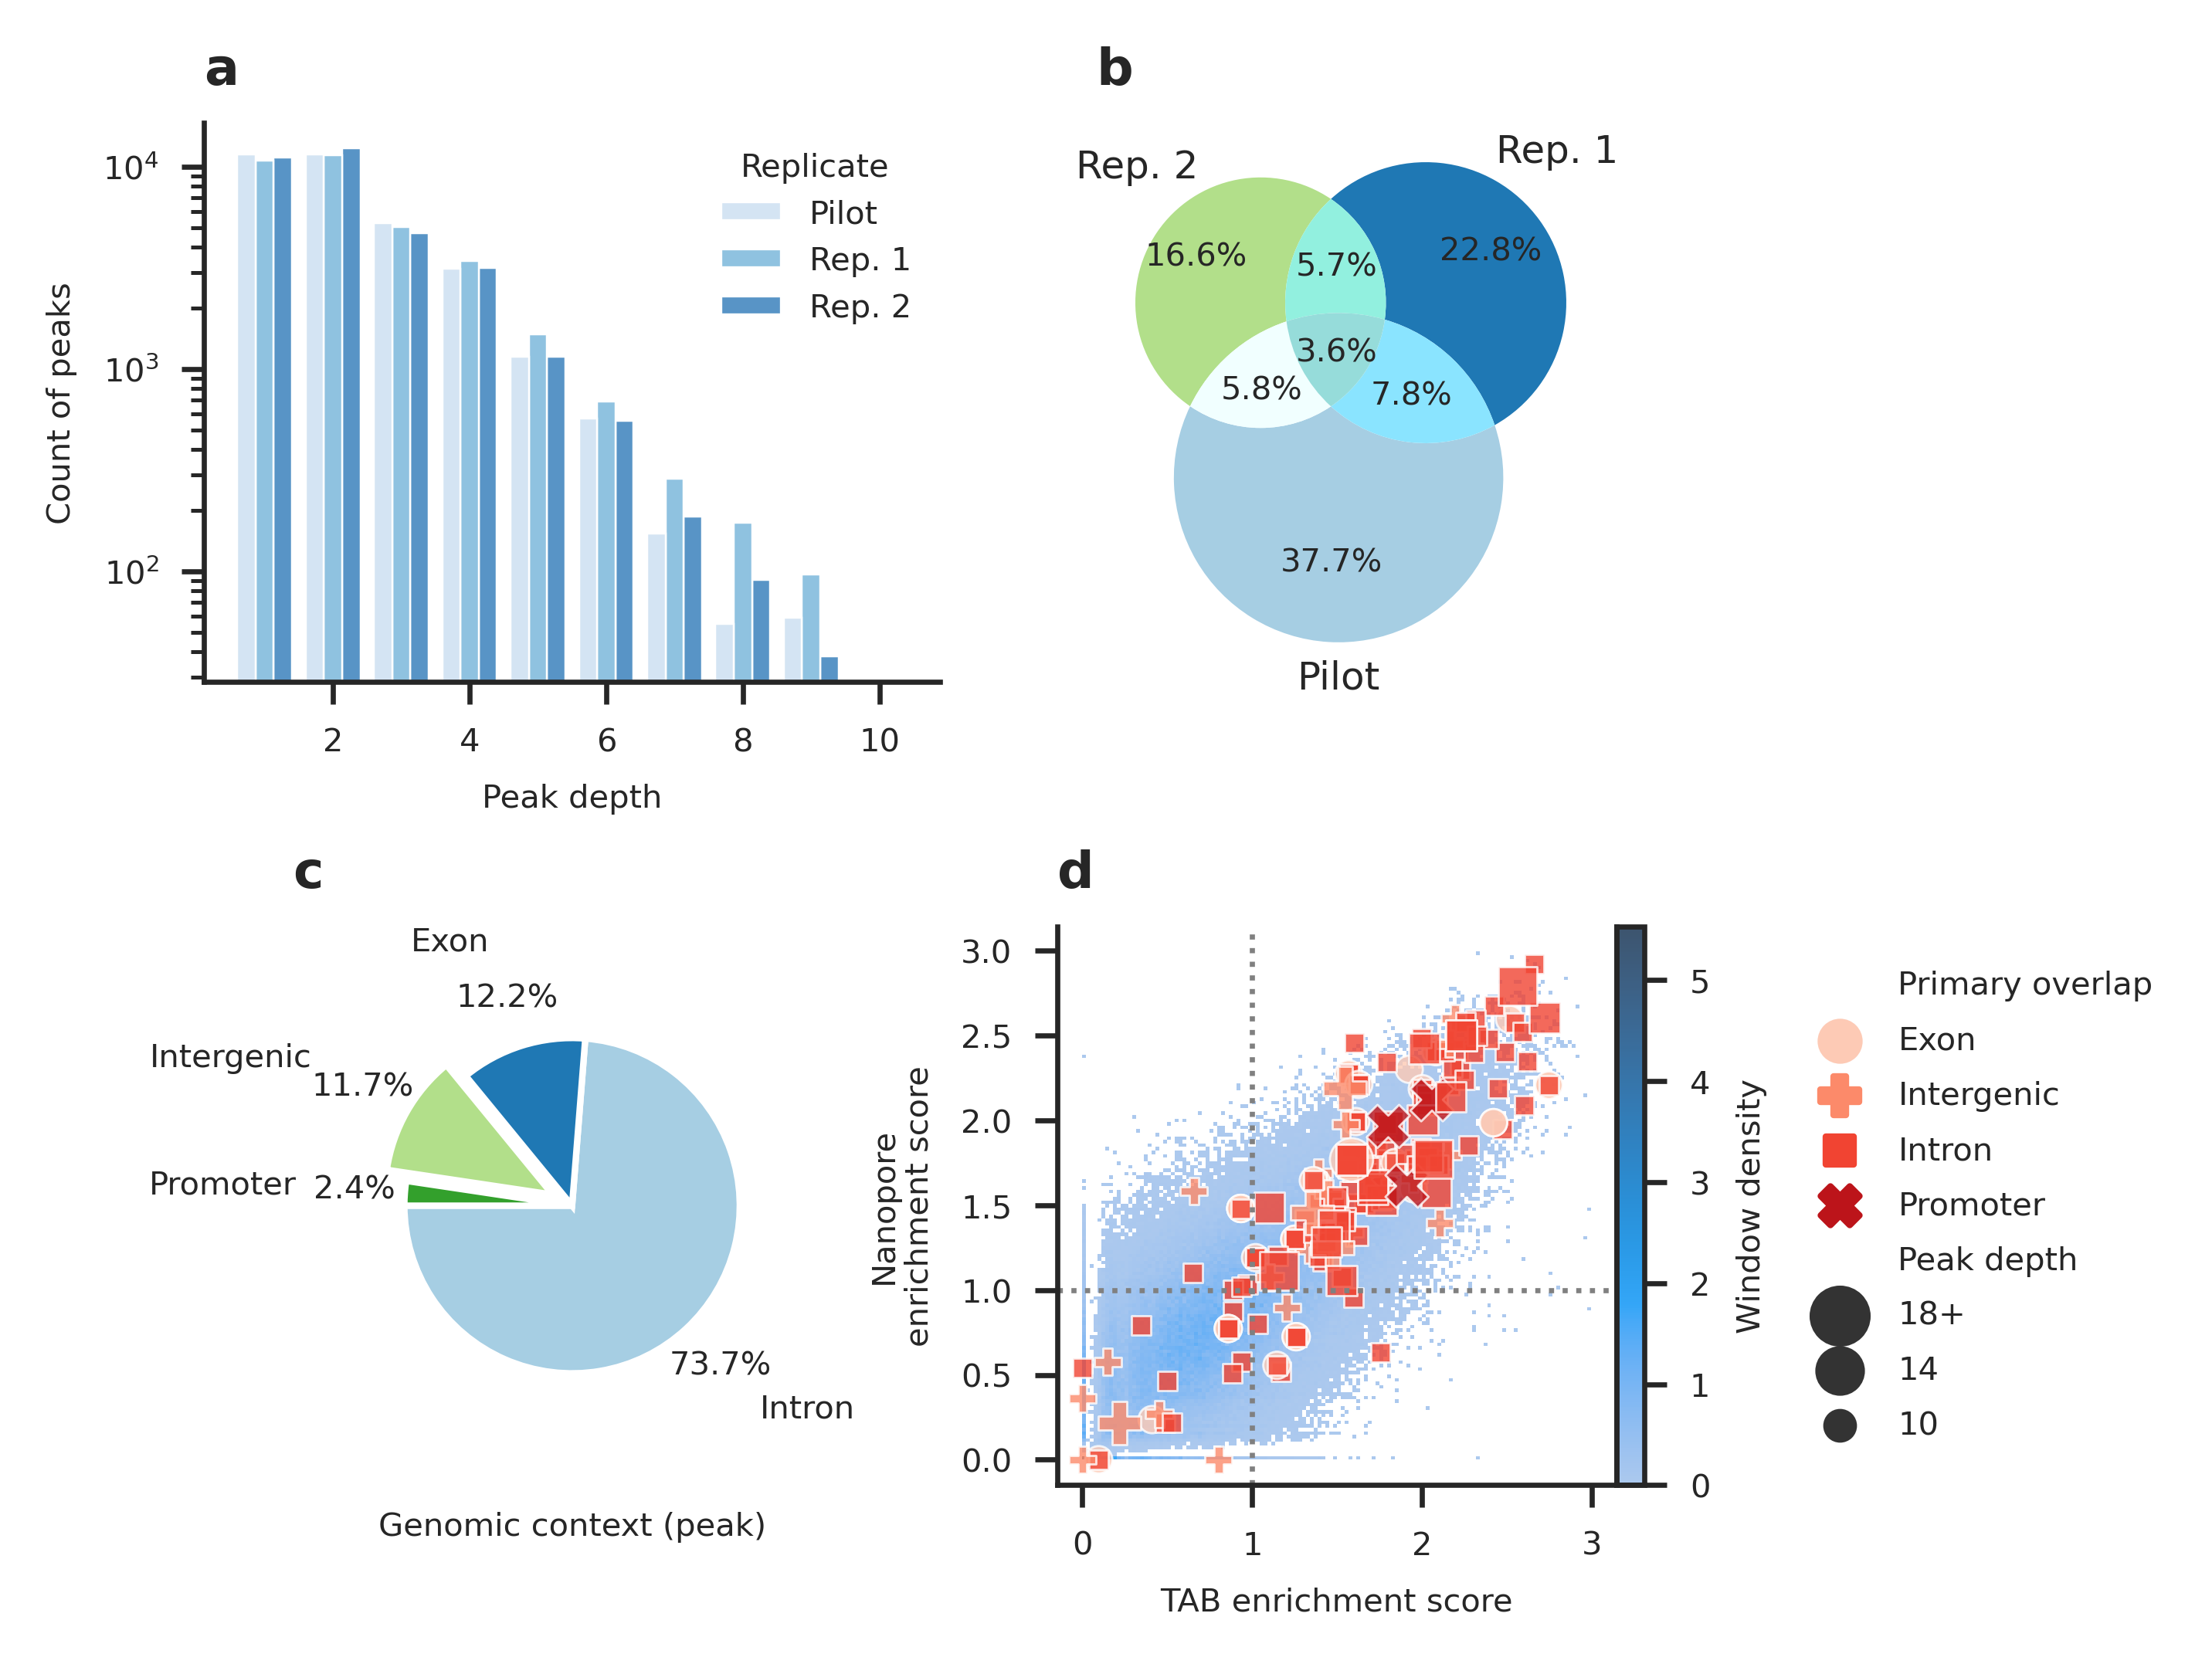

In [63]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib_venn import venn3
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set_style("ticks")
mpl.rc('font', size=5)

fig = plt.figure(figsize=(120/25.4, 180/2/25.4), dpi=600)
gs = GridSpec(2, 2, fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1:])

colors = [sns.color_palette("Paired", 4)[2], sns.color_palette("Paired", 4)[0], sns.color_palette("Paired", 4)[1], sns.color_palette("Paired", 4)[3]]

# Panel 1 # 
binmax = 10
sns.histplot(histplot_df, x="peakDepth", multiple="dodge", 
             hue="Replicate", hue_order=["Pilot", "Rep. 1", "Rep. 2"], palette=sns.color_palette("Blues", 3),
             binrange=(1, binmax), discrete=True, shrink=0.8, log_scale=(False, True), element="bars",  
             ax=ax1)
ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")
ax1.set_xlabel("Peak depth")
ax1.set_ylabel("Count of peaks")

sns.move_legend(ax1, "upper right", frameon=False)

# Panel 2 # 

VennDiagrammer(ip_r0_pr, ip_r1_pr, ip_r2_pr, ax=ax2)
ax2.set_title("b", loc="left", fontsize=8, fontweight="bold")

# Panel 2 # 
ax3.pie(pie_values, labels=pie_labels, startangle=180, explode=(0, 0, .1, 0), radius=0.75, 
        colors=sns.color_palette("Paired", 4), autopct="%1.1f%%",
        pctdistance=1.3, labeldistance=1.65)

ax3.set_title("c", loc="left", fontsize=8, fontweight="bold")
ax3.set_xlabel("Genomic context (peak)")

# Panel 3 # 

div = make_axes_locatable(ax4)
cax = div.append_axes("right", size="5%", pad=0)

sns.histplot(tiles.as_df().query("CpG_count >= 6"), x="log2enrichment_5hmC_TAB", y="log2enrichment_5hmC_Nanopore", 
            stat="density", 
            cbar=True, cbar_kws={"label" : "Window density", "pad" : 0}, cbar_ax=cax, 
            ax=ax4)
sns.scatterplot(annotated_tiled_peaks.query("CpG_count >= 6 & total_peakDepth >= 10 & total_peakDepth <= 30").sort_values(["total_peakDepth", "Primary overlap"]), 
               x="log2enrichment_5hmC_Nanopore", y="log2enrichment_5hmC_TAB", 
               size="Peak depth", size_order=["18+", 14, 10],
               alpha=.8, 
               style="Primary overlap", style_order=["Exon", "Promoter", "Intron", "Intergenic"],
               hue="Primary overlap", palette="Reds", 
               ax=ax4)

ax4.axvline(x=1, ls=":", c="grey", lw=0.8)
ax4.axhline(y=1, ls=":", c="grey", lw=0.8)
ax4.set_xlabel("TAB enrichment score")
ax4.set_ylabel("Nanopore\nenrichment score")
ax4.set_aspect("equal")
ax4.set_title("d", loc="left", fontsize=8, fontweight="bold")
sns.move_legend(ax4, "center", frameon=False, bbox_to_anchor=(1.65, .5), labelspacing=.75)

sns.despine()

plt.tight_layout()
plt.savefig("/u/n/doh28/Documents/Nanopore_HMC/Figures/hMeDIP_extras.png", dpi=600)


# Lambda negative control strand

In [94]:
from common import readModbam2bed
import pandas as pd

r1_basecalls = readModbam2bed("../../data/cbm1_ip/rep1_23_16_08/lambda_basecalls/lambda_phage_rep1_modbases.bed", 1, False, True).query("chromStart > 45041")
r2_basecalls = readModbam2bed("/mnt/data1/doh28/data/cbm1_ip/rep2_23_05_09/lambda_basecalls/cbm1_ip_rep2_lambda_basecalls_basecalls.bed", 1, False, True).query("chromStart > 45041")

In [95]:
r_all = pd.merge(r1_basecalls, r2_basecalls, "outer", on=["chromosome", "chromStart", "chromEnd"], suffixes=["_R1", "_R2"])

In [96]:
df_list = []
for index, rep in enumerate([r1_basecalls, r2_basecalls]):
    total_c = rep["readCount"].sum()
    total_hmc = rep["N_hmC"].sum() 
    total_mc = rep["N_mC"].sum()

    fpr_hmc = total_hmc/total_c*100
    fpr_mc = total_mc/total_c*100

    fpr_df = pd.DataFrame({
        "Replicate" : index,
        "Modification" : ["5mC", "5hmC"],
        "False positive rate (%)" : [fpr_mc, fpr_hmc]
    })
    df_list.append(fpr_df)
both = pd.concat(df_list)

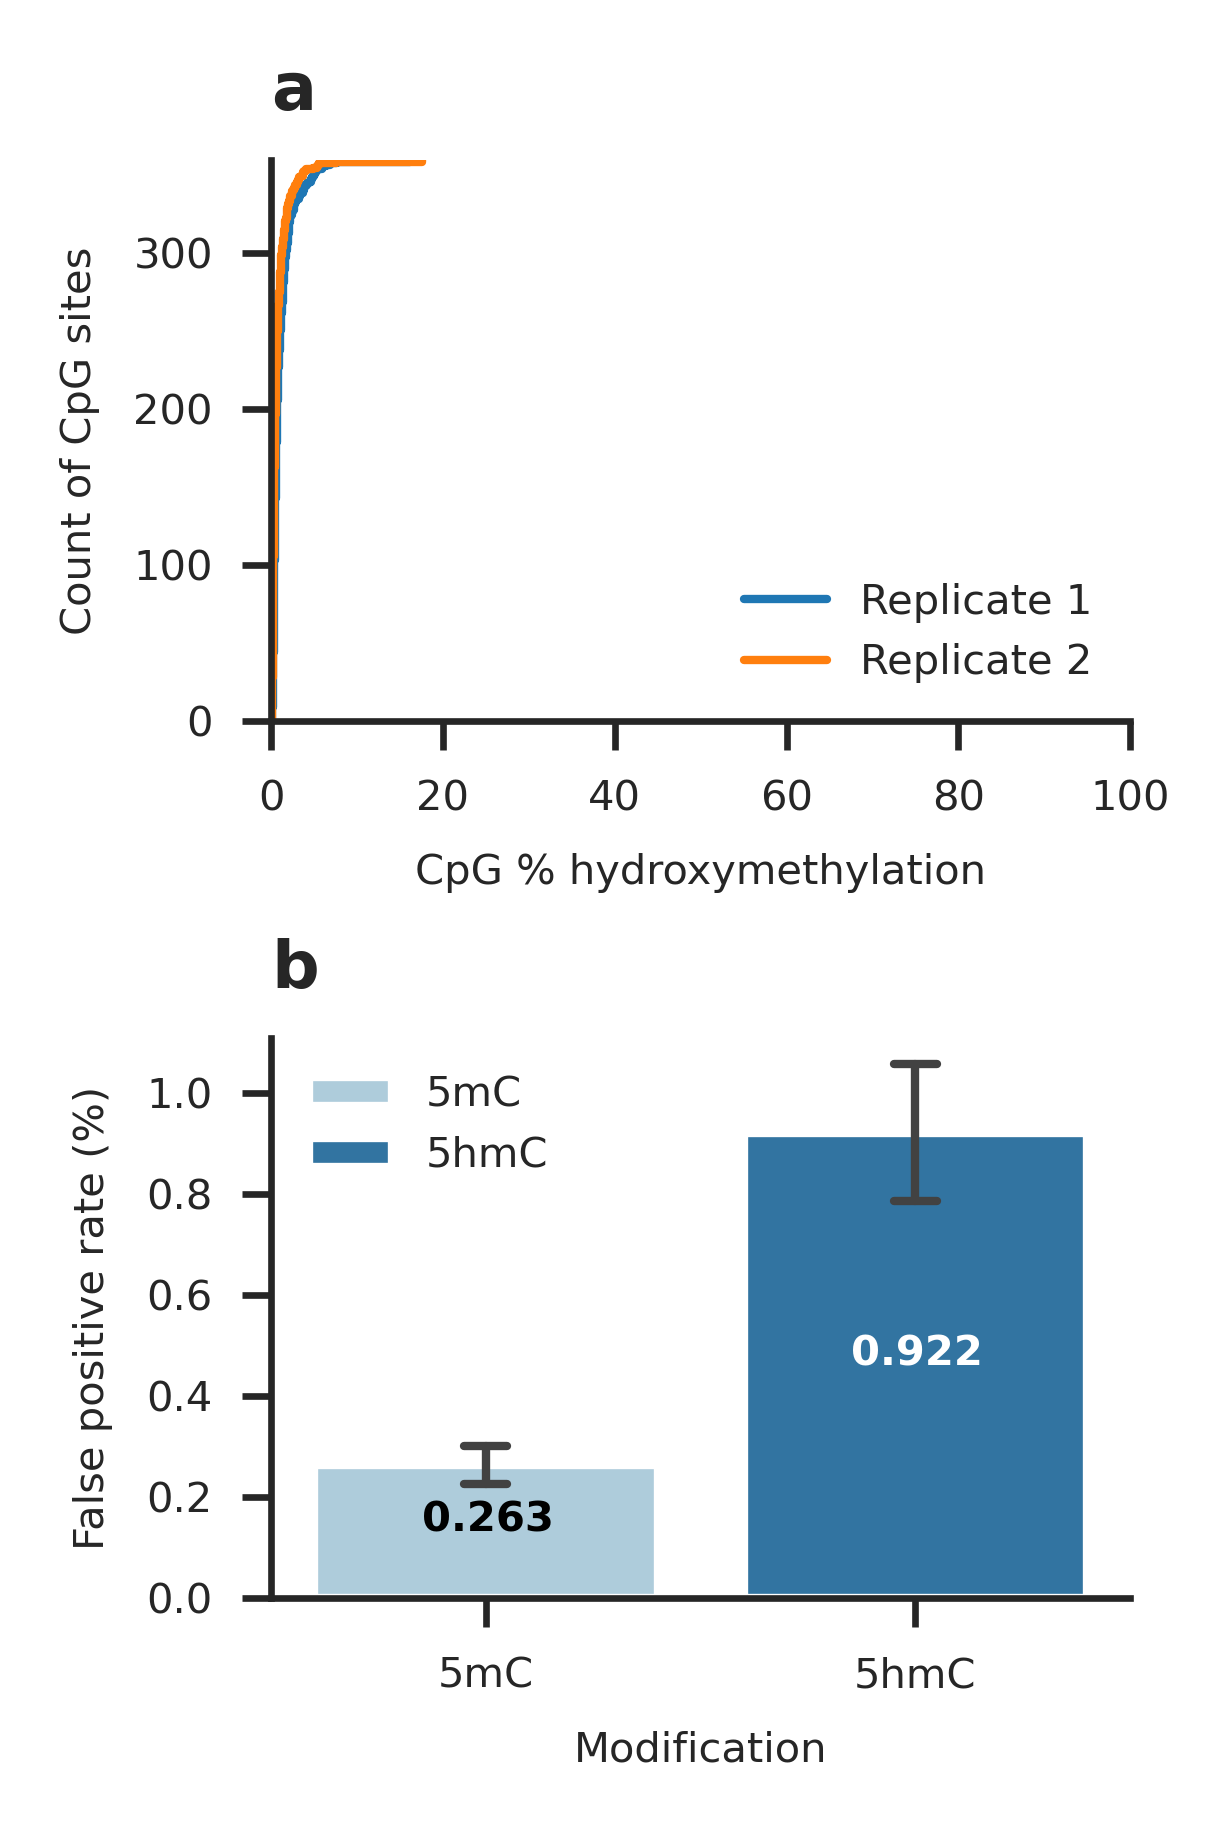

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

sns.set_style("ticks")
mpl.rc('font', size=5)

fig = plt.figure(figsize=(2, 3), dpi=600)

ax1 = plt.subplot2grid((2, 1), (0, 0))
ax2 = plt.subplot2grid((2, 1), (1, 0))

colors = [sns.color_palette("Paired", 2)[0], sns.color_palette("Paired", 2)[1]]

mc_mean = both.query("Modification == '5mC'")["False positive rate (%)"].mean()
hmc_mean = both.query("Modification == '5hmC'")["False positive rate (%)"].mean()

ax1.set_title("a", loc="left", fontsize=8, fontweight="bold")
ax1.set_xlabel("CpG % hydroxymethylation")
ax1.set_ylabel("Count of CpG sites")
ax1.set_xlim((0, 100))
# ax1.set_ylim(0, 1.0)


sns.ecdfplot(r_all, x="percentMeth_5hmC_R1", stat="count",  label="Replicate 1", lw=1, 
             ax=ax1)
sns.ecdfplot(r_all, x="percentMeth_5hmC_R2", stat="count",  label="Replicate 2", lw=1, 
             ax=ax1)
ax1.legend(loc="lower right", frameon=False)

sns.barplot(both, x="Modification", y="False positive rate (%)", 
            capsize=.1, errwidth=1, palette="Paired",
            hue="Modification", dodge=False, 
            ax=ax2)
sns.move_legend(ax2, loc="upper left", title=None, frameon=False)

ax2.text(0-.15, mc_mean/2, f"{round(mc_mean, 3)}", c="k", fontweight="bold")
ax2.text(1-.15, hmc_mean/2, f"{round(hmc_mean, 3)}", c="w", fontweight="bold")
ax2.set_title("b", loc="left", fontsize=8, fontweight="bold")

sns.despine()

fig.tight_layout()